<a href="https://colab.research.google.com/github/digwit678/Can-Language-Models-Follow-Discussions/blob/main/probing_sw7_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

# Structure of scraped discussions

`dumped_discussions_first.pickle` includes a 17.832 discussions. Every discussion entry looks as follows:

````
{
   "title": ... // Title of the kialo discussion
   "background info": ... // Background information of the kialo discussion
   "discussion": {
      "claims": [...] // All claims of the full discssion, more details later
      "locations": [...] // Location of the claims, more details later
      "touchedClaimOrLocationIds": // not relevant
   }
}
````

## Structure of claims
Every claim entry of a discussion has the following structure:
````
{
   "id": xxxx.yy // id of the claim it-self where xxxx is the discussion id, when yy is equal to 0 it is the root claim
   "authorId": "0077c272-1fdc-4202-a06a-160482dfc12d",
   "created": 1382962412430,
   "version": 2,
   "text": "Anonymous currency discussions", // text of the claim, often empty or not relevant for root claim (i.e. 333.0)
   "lastModifiedForSitemaps": 1382962412430
}
````
## Structure of positions
There is a location entry for every claim which is not the root claim. This entry describes the position of the claim and therefore its target.
````
{
   "id":"333.1228", // id of the relation
   "targetId":"333.355", // id of the source claim
   "version":1,
   "isOrigin":true,
   "authorIdentityId":"54d22c9853057c01262a7192",
   "created":1395770583629,
   "parentId":"333.338", // id of the target claim
   "relation":1, // 1 if relation is Pro, -1 if relation is Con
   "isDeleted":false, // ignore if it is true
   "lastModifiedForSitemaps":1520166022299
}
````

---



**Observation**: The same node (see 333.1) is being saved n times, whereas n = number of outgoing edges

General ID-Structure: [DiscussionID . ClaimID], claim_ids are not always in chronological order (so it not always follows 0.2 on 0.1)
Some ID´s are also skipped / missing / deleted


Nodes and edges being saved in igraph-sequences

In [ ]:
for i, node in enumerate(example_graph_nodes):
  if i < 10:
    print("source: ", node["name"]["id"])
    print("target: ", example_graph_edges[i].target_vertex["name"]["id"])
    print("-----------------------------------")



source:  333.0
target:  333.2
-----------------------------------
source:  333.1
target:  333.3
-----------------------------------
source:  333.2
target:  333.7
-----------------------------------
source:  333.3
target:  333.12
-----------------------------------
source:  333.4
target:  333.17
-----------------------------------
source:  333.5
target:  333.18
-----------------------------------
source:  333.7
target:  333.19
-----------------------------------
source:  333.9
target:  333.2
-----------------------------------
source:  333.1
target:  333.21
-----------------------------------
source:  333.11
target:  333.22
-----------------------------------


In [ ]:
 # local path
#pickle_file_path = "../../../data_preparation/kialo_data/3_parsed_node_data/parsed_discussion_graphs.pickle"
#with open(pickle_file_path, 'rb') as f:
   # parsed_discussion_graphs = pickle.load(f)

In [ ]:
#!pip install igraph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.2 MB/s eta 0:00:00


In [2]:
import random
from random import shuffle
from typing import List, Tuple, Set, Optional
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import math
from math import ceil
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import train_test_split
import pickle
#import igraph as ig
import yaml
import os
import re
import ast

In [3]:
random.seed(42)

In [4]:
base_path_gdrive = "/content/drive/MyDrive/Can Language Models Follow Discussions?/"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
def load(path_end, file_type="csv"):
  """
  - path_end: provide number + file name
  - file_type: "pkl" for pickle or "" for csv

  """
  base_path_gdrive = r"/content/drive/MyDrive/Can Language Models Follow Discussions?/"
  path = base_path_gdrive + path_end + "." + file_type
  if file_type == "pkl":
    with open (path , 'rb') as f:
        file_out =  pickle.load(f)
  else:
        file_out = pd.read_csv(path)
  print(path, "loaded.")
  return file_out

In [7]:
node_df = load("1/node_attributes_v5",file_type="pkl")

/content/drive/MyDrive/Can Language Models Follow Discussions?/1/node_attributes_v5.pkl loaded.


In [ ]:
#node_df.drop("Unnamed: 0",axis = 1,inplace = True) only needed when loading csv

In [ ]:
node_df.head()

,Index,Graph_Index,Node_ID,Depth,Breadth,Parent Node,Base_Claim_ID,Base_Claim_Text,Claim_Text,Outgoing_Node_IDs,Relations_To_Outgoing,Normalized_Stance_Score
0,0,0,333.000,0,0,NaN,333.0,Anonymous currency discussions,Anonymous currency discussions,[333.167],[0],0.000000
1,1,0,333.167,1,0,333.000,333.0,Anonymous currency discussions,"Cryptocurrencies, such as Bitcoin and others, ...","[333.338, 333.168, 333.644, 333.69, 333.794, 3...","[-1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1]",0.454545
2,2,0,333.338,2,0,333.167,333.0,Anonymous currency discussions,Cryptocurrency mining is a waste of resources.,"[333.339, 333.34, 333.355, 333.694, 333.824, 3...","[1, -1, 1, -1, -1, -1, 1]",-0.142857
3,3,0,333.168,2,1,333.167,333.0,Anonymous currency discussions,Cryptocurrencies and the technologies built on...,"[333.891, 333.894]","[1, 1]",1.000000
4,4,0,333.644,2,2,333.167,333.0,Anonymous currency discussions,A cryptocurrency is harder to counterfeit than...,"[333.646, 333.84, 333.697]","[-1, 1, 1]",0.333333


In [ ]:
STOP

In [ ]:
# Data Cleaning for probe 1 - reworked (needed for csv loaded files, should not be needed for pickle files)
# Function to convert string representation of list to list of integers
def convert_to_int_list(s):
    return list(map(int, s.strip('[]').split(','))) if s.strip('[]') else []

# Apply the function to the 'Relations_To_Outgoing' column
node_df['Relations_To_Outgoing'] = node_df['Relations_To_Outgoing'].apply(convert_to_int_list)

In [ ]:
# Data Cleaning for probe 1 - reworked
# Function to convert string representation of list to list of floats
def convert_to_float_list(s):
    return [float(x.strip()) for x in s.strip('[]').split(',')] if s.strip('[]') else []

# Apply the function to the 'Outgoing_Node_IDs' column
node_df['Outgoing_Node_IDs'] = node_df['Outgoing_Node_IDs'].apply(convert_to_float_list)

# Check the first few rows to confirm
node_df.head()

,Index,Graph_Index,Node_ID,Depth,Breadth,Parent Node,Base_Claim_ID,Base_Claim_Text,Claim_Text,Outgoing_Node_IDs,Relations_To_Outgoing,Normalized_Stance_Score
0,0,0,333.000,0,0,NaN,333.0,Anonymous currency discussions,Anonymous currency discussions,[333.167],[0],0.000000
1,1,0,333.167,1,0,333.000,333.0,Anonymous currency discussions,"Cryptocurrencies, such as Bitcoin and others, ...","[333.338, 333.168, 333.644, 333.69, 333.794, 3...","[-1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1]",0.454545
2,2,0,333.338,2,0,333.167,333.0,Anonymous currency discussions,Cryptocurrency mining is a waste of resources.,"[333.339, 333.34, 333.355, 333.694, 333.824, 3...","[1, -1, 1, -1, -1, -1, 1]",-0.142857
3,3,0,333.168,2,1,333.167,333.0,Anonymous currency discussions,Cryptocurrencies and the technologies built on...,"[333.891, 333.894]","[1, 1]",1.000000
4,4,0,333.644,2,2,333.167,333.0,Anonymous currency discussions,A cryptocurrency is harder to counterfeit than...,"[333.646, 333.84, 333.697]","[-1, 1, 1]",0.333333


In [ ]:
save(node_df,"node_attributes_v5",1,  output_type = "pkl" )

File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/1/node_attributes_v5.pkl


# Utility Functions

In [15]:
def split_into_folds(df, num_folds=4):
    """
    Accepts dataframe without set columns and generates specified number of folds,
    where each claim appears in the test set only once
    """
    # Initialize set columns
    for i in range(num_folds):
        col_name = f'set-{i}'
        df[col_name] = None

    # Number of rows in the DataFrame
    num_rows = len(df)

    # Assign each row to a test set exactly once
    for i in range(num_folds):
        test_indices = range(i, num_rows, num_folds)
        df.loc[test_indices, f'set-{i}'] = 'test'

    # Assign each row to a dev set exactly once
    # Start the dev set one position shifted from the test set
    for i in range(num_folds):
        dev_indices = range((i + 1) % num_folds, num_rows, num_folds)
        df.loc[dev_indices, f'set-{i}'] = 'dev'

    # Fill the remaining with 'train'
    df.fillna('train', inplace=True)

    return df

# Sample DataFrame for testing
df_sample = pd.DataFrame({'Index': range(10), 'Graph_Index': range(10, 20)})
df_result = split_into_folds(df_sample)
print(df_result)


   Index  Graph_Index  set-0  set-1  set-2  set-3
0      0           10   test  train  train    dev
1      1           11    dev   test  train  train
2      2           12  train    dev   test  train
3      3           13  train  train    dev   test
4      4           14   test  train  train    dev
5      5           15    dev   test  train  train
6      6           16  train    dev   test  train
7      7           17  train  train    dev   test
8      8           18   test  train  train    dev
9      9           19    dev   test  train  train


In [18]:
def save_all_folds_in_one(df_folds, probe_name, probe_number=None, base_path_gdrive="/content/drive/MyDrive/Can Language Models Follow Discussions?", num_folds=4):
    """
    Saves all the folds into a single DataFrame and returns it.
    """

    """
    Saves the YAML configuration file and DataFrame fold in the specified directory structure.

    Parameters:
    - fold: DataFrame containing the data for the probing task.
    - probe_name: Name of the probe.
    - probe_number: Number assigned to the probing task.
    - base_path_gdrive: The base path where the data should be saved.
    #- variation_name: Name of the variation folder if a variation exists.
    - num_folds: Number of folds for the probe. If set to 1, all data will be in a single fold.

    Notes:
    - The YAML file is saved only once per variation, not per fold.
    - The directory structure is created as needed: base directory -> variation directory -> set directory.
    - The function dynamically determines the number of unique labels in the DataFrame and adjusts the YAML configuration accordingly.
    """

    # Target column order
    target_columns = ['index', 'inputs', 'context', 'topic', 'org_label', 'set-0'] + [f'set-{i}' for i in range(1, num_folds)] + ['id', 'string_label', 'label']

    # Reorder the columns to match the target order
    final_df = df_folds[target_columns]

    print("After column alignment in save_all_folds_in_one: ", final_df.head())

    # Create directories if they don't exist
    base_dir = f"{base_path_gdrive}/{probe_number}"
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)

    # Saving Folds.csv
    final_df.to_csv(os.path.join(base_dir, "folds.csv"), index=False)

    # Generating YAML file
    num_labels = len(final_df['org_label'].unique())
    #num_labels = 2
    label_terminology = {1: "", 2: "bi", 3: "tri", 4: "tetra", 5: "penta", 6: "hexa", 7: "hepta", 8: "octa", 9: "ennea", 10: "deca"}

    yaml_filename = f"config-{label_terminology.get(num_labels, 'multi')}-none.yaml"

    config_content = {
        'control_task_type': 'NONE',
        'num_inputs': 2,
        'num_labels': num_labels,
        'num_probe_folds': num_folds,
        'probe_name': f"probe_{probe_number}-{probe_name}",
        #'probe_task_type': f'SENTENCE_PAIR_{label_terminology.get(num_labels, "MULTI").upper()}',
        'probe_task_type': f'SENTENCE_PAIR_BI',
        'probes_samples_path': f'sample_probes/probe_{probe_number}-{probe_name}'
    }

    # Saving YAML
    with open(os.path.join(base_dir, yaml_filename), 'w') as file:
        yaml.dump(config_content, file, default_flow_style=False)

    print(f"Saved data and YAML configuration in {base_dir}.")

    return final_df


In [ ]:
def save(df, name, probing_task_nr, input_type = "df", output_type = "csv"):
  base_path_gdrive= "/content/drive/MyDrive/Can Language Models Follow Discussions?/"
  full_file_path = base_path_gdrive + f"{probing_task_nr}/{name}.{output_type}"
  if input_type == "df":
    if output_type == "csv":
          df.to_csv(full_file_path)
          #print(f"{name}.{output_type} saved to {base_path_gdrive}{probing_task_nr}/")
    if output_type == "pkl":
          df.to_pickle(full_file_path)
  if input_type == "dc":
    if output_type == "pkl":
        with open(full_file_path, 'wb') as f:
          pickle.dump(full_file_path, f)
  print(f'File saved as {full_file_path}')

In [ ]:
def save(data, name, probing_task_nr, input_type="df", output_type="csv"):
    base_path = "/content/drive/MyDrive/Can Language Models Follow Discussions?/"  # Adjusted the path as internet access is disabled
    full_file_path = f"{base_path}{probing_task_nr}/{name}.{output_type}"

    if input_type == "df":
        if output_type == "csv":
            data.to_csv(full_file_path, index=False)
        elif output_type == "pkl":
            data.to_pickle(full_file_path)

    elif input_type == "list":
        if output_type == "csv":
            # Assuming that the list contains tuples with the same structure for all elements
            df = pd.DataFrame(data)
            df.to_csv(full_file_path, index=False)
        elif output_type == "pkl":
            with open(full_file_path, 'wb') as f:
                pickle.dump(data, f)

    elif input_type == "dict":
        if output_type == "pkl":
            with open(full_file_path, 'wb') as f:
                pickle.dump(data, f)

    print(f"File saved as {full_file_path}")

# Test the function with a sample DataFrame and list
#sample_df = pd.DataFrame({'col1': [1, 2, 3], 'col2': ['a', 'b', 'c']})
#sample_list = [(1, 'a'), (2, 'b'), (3, 'c')]

# Uncomment the following lines to actually save the files.
# They are commented to prevent file-writing in this example environment.
# save(sample_df, "sample_df", "Probing_Task_4", input_type="df", output_type="csv")
# save(sample_list, "sample_list", "Probing_Task_4", input_type="list", output_type="csv")

# Assuming 'examples' contains your list of generated data
#save(examples, "generated_examples", "Probing_Task_4", input_type="list", output_type="csv")


In [ ]:
# Function to calculate max depth from the base claim
def calculate_max_depth(graph, base_claim_index=0):
    return max([len(path) for path in graph.get_all_shortest_paths(base_claim_index)])

## deprecated

In [ ]:
def append_topic_to_first_claim(inputs_tuple):
    # Extracting the first and second claims

    first_claim, second_claim = inputs_tuple

    # Appending the topic to the first claim
    new_first_claim = f"{inputs_tuple}. {first_claim}"

    # Creating a new tuple with the modified first claim
    new_input = new_first_claim, second_claim

    return new_input

In [ ]:
def save_final_files_to_drive(probing_example_nr, df, num_inputs, subsample=False, additional_info="", control_task_type="NONE", num_labels=2, num_probe_folds=1, probe_task_type="", probes_samples_path="sample_probes"):
    """
    Save the final probing files to Google Drive.

    Parameters:
    - probing_example_nr: The probing example number used in the folder path.
    - df: The DataFrame to save.
    - num_inputs: Number of input sentences (1 for single sentence, 2 for two sentences).
    - subsample: Boolean flag to indicate if it's a subsample or full data (default: False).
    - additional_info:  is added to the end of the probe name if specified
    - control_task_type: The type of control task (default: "NONE").
    - num_labels: Number of labels (default: 2).
    - num_probe_folds: Number of probing folds (default: 1).
    - probe_task_type: The task type of the probe (default: "SENTENCE").
    - probes_samples_path: Relative path to the probe (default: "sample_probes").
    """

    # Determine folder based on subsample or full
    folder_type = "subsample" if subsample else "full"

    # Set the base path
    base_path = f"/content/drive/MyDrive/Can Language Models Follow Discussions?/{probing_example_nr}/final probing files/{folder_type}/{(additional_info if additional_info != '' else '')}"

    # Create folder if not exists
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    # perm: bei encodierung werden wort geshuffelt

    # Determine the config file name
    config_name = "config"
    if num_inputs == 2:
        config_name += "-bi"
    if subsample:
        config_name += "-rand" # TODO: rand= random weights / random init (baseline) // randomization: labels random shuffling (lower bound performance), da modell eine lineare regression kann es den Task noch lernen , was wir nicht wollen : Selektivität der Probe (lernt das Modell oder nicht: grösserer Unterschied --> höhere Selektivität --> lernt weniger (besser zum proben))
    config_name += "-none.yaml"

    # Create YAML config content: id = probe name , id auch in path
    config_content = {
        'control_task_type': control_task_type,
        'num_inputs': num_inputs,
        'num_labels': num_labels,
        'num_probe_folds': num_probe_folds,
        'probe_name': f"probe-{('single' if num_inputs == 1 else 'two')}_sentence_probing_task_{(additional_info if additional_info != '' else '')}_{probing_example_nr}", # unique
        'probe_task_type': ("SENTENCE" if num_inputs == 1 else "SENTENCE_PAIR_BI") if probe_task_type =="" else probe_task_type,
        'probes_samples_path': f"{probes_samples_path}/{('single' if num_inputs == 1 else 'two')}_sentence_probing_task"  # replace with probename , base path always the same (probing_files)
    }

    # Save YAML file
    with open(base_path + config_name, 'w') as file:
        yaml.safe_dump(config_content, file, default_flow_style=False)

    # Save DataFrame as CSV
    df.to_csv(base_path + "folds.csv", index=True)

    print(f"Files saved at {base_path}")


In [ ]:
def save_dataframe_to_drive(probing_example_nr, df, file_type='e', task_name='task'):
    # Set the base path
    base_path = f"/content/drive/MyDrive/Can Language Models Follow Discussions?/{probing_example_nr}/final probing files/"

    # Create the filename
    filename = f"{probing_example_nr}_{task_name}_data"

    # Full file path
    if file_type == 'p':
        full_file_path = f"{base_path}{filename}.pkl"
        df.to_pickle(full_file_path)
    else:
        full_file_path = f"{base_path}{filename}.xlsx"
        df.to_excel(full_file_path, index=False)

    print(f"File saved at {full_file_path}")

# Example usage:
# save_dataframe_to_drive(1, df, file_type='e', task_name='my_task')


In [ ]:
def print_first_n_entries(dictionary, n, max_inner_items=5):
    """
    Print the first 'n' entries of a nested dictionary, showing only the first 'max_inner_items' key-value pairs of the inner dictionary at each depth level.

    Args:
        dictionary (dict): The nested dictionary to print.
        n (int): The number of entries to print.
        max_inner_items (int): The maximum number of key-value pairs to print from the inner dictionary at each depth level.

    Returns:
        None
    """
    def print_nested_dict(d, depth):
        if depth >= max_depth:
            return

        for key, value in d.items():
            if len(entries) >= n:
                return

            entries.append((key, value))
            print(f"Entry {len(entries)}:")
            print(f"Key: {key}")
            print("Value:")

            if isinstance(value, dict):
                sub_dict = {k: value[k] for k in list(value)[:max_inner_items]}
                print_nested_dict(sub_dict, depth + 1)
            else:
                print(f"  {value}\n")

    max_depth = max_inner_items
    entries = []

    print_nested_dict(dictionary, 0)



In [ ]:

def create_general_dataframe(claim_pairs, context, topics, org_labels, slabels, identifiers):
    """
    Creates a DataFrame for probing tasks with the given parameters.

    Parameters:
        claim_pairs (list of tuple): List of tuples where each tuple contains two claims to compare.
        context (list of str): List of context for each claim pair if specified else left empty/NaN.
        topics (list of str): Base Claim Text / Discussion Topic
        org_labels (list of str): List of original labels as string (e.g. "Consecutive", "Non-Consecutive", etc.).
        labels (list of int): List of integer labels (1 for "Consecutive", 0 for "Non-Consecutive").
        identifiers (list of int): List of unique identifiers for each claim pair.

    Returns:
        DataFrame: A DataFrame containing the data in the specified format.
    """

    df = pd.DataFrame({
        'inputs': claim_pairs,
        'context': context,
        'topic': topics,
        'org_label': org_labels,
        'id': identifiers,
        'string_label': labels,
        'label': labels  # assuming that string_label and label are the same
    })

    # Split
    train, test = train_test_split(df, test_size=0.2, random_state=42)
    train, dev = train_test_split(train, test_size=0.25, random_state=42)

    # Assign set
    train['set-0'] = 'train'
    dev['set-0'] = 'dev'
    test['set-0'] = 'test'

    # Combine
    final_df = pd.concat([train, dev, test])

    return final_df


# Probing 1: Affirming or Opposing Claims ?

In [ ]:
# Import required libraries
from tqdm import tqdm
import random
import pandas as pd

# Initialize random seed for reproducibility
random.seed(42)

def random_walk(start_row, target_depth, claim_sequence, stance_sequence, current_stance, discussion):
    print("[Debug] Starting random walk...")
    next_claim_row = start_row
    for depth in range(1, target_depth + 1):
        if depth > 0:  # Exclude the base claim from the sequences
            claim_sequence.append(next_claim_row['Node_ID'])
            stance_sequence.append(current_stance)

        directly_responding_claims = next_claim_row['Outgoing_Node_IDs']
        stances = next_claim_row['Relations_To_Outgoing']

        # Check for discrepancies in length between the two lists
        min_length = min(len(directly_responding_claims), len(stances))
        if min_length == 0:
            print("[Debug] Exiting the loop, either list is empty.")
            break  # Exit the loop if either list is empty

        # Select a random index within the minimum length to avoid IndexError
        choice_idx = random.choice(range(min_length))

        chosen_claim = directly_responding_claims[choice_idx]
        chosen_stance = stances[choice_idx]

        current_stance *= chosen_stance  # Update the current_stance
        print(f"[Debug] Current stance updated to {current_stance}")

        # Find the next claim row based on the chosen_claim
        next_claim_candidates = discussion[discussion['Node_ID'] == chosen_claim]
        if next_claim_candidates.empty:
            print("[Debug] Exiting the loop, next_claim doesn't exist.")
            break  # Exit the loop if the next_claim doesn't exist

        next_claim_row = next_claim_candidates.iloc[0]  # Update next_claim_row
    return current_stance, next_claim_row

def generate_stance_data(node_df, max_examples=200000):
    print("[Debug] Generating Stance Data...")

    stance_pairs = []
    unique_pairs = set()
    target_stance = 1
    unbalanced_count = 0
    max_trials = 50

    grouped_by_discussion = node_df.groupby('Graph_Index')

    with tqdm(total=grouped_by_discussion.ngroups, desc="Processing Discussions") as pbar:
        for discussion_id, discussion in grouped_by_discussion:
            pbar.update(1)
            print(f"[Debug] Processing discussion {discussion_id}")

            if len(discussion) < 3:
                print("[Debug] Skipping discussion, less than 3 claims.")
                continue

            base_claim_candidates = discussion[discussion['Depth'] == 0]
            if not base_claim_candidates.empty:
                base_claim_row = base_claim_candidates.iloc[0]
            else:
                print("[Debug] Skipping discussion, no base claim.")
                continue  # Skip this discussion and move to the next one

            max_depth = discussion['Depth'].max()
            claim_sequence1, claim_sequence2 = [], []
            stance_sequence1, stance_sequence2 = [], []
            current_stance1, current_stance2 = 1, 1

            target_depth1 = random.randint(1, max_depth)
            print(f"[Debug] Target depth for first walk: {target_depth1}")
            current_stance1, last_claim1 = random_walk(base_claim_row, target_depth1, claim_sequence1, stance_sequence1, current_stance1, discussion)

            trial_count = 0
            while True:
                trial_count += 1
                if trial_count > max_trials:
                    print("[Debug] Maximum trials reached, breaking the loop.")
                    break

                target_depth2 = random.randint(1, max_depth)
                print(f"[Debug] Target depth for second walk: {target_depth2}")
                claim_sequence2.clear()
                stance_sequence2.clear()
                current_stance2 = 1
                current_stance2, last_claim2 = random_walk(base_claim_row, target_depth2, claim_sequence2, stance_sequence2, current_stance2, discussion)

                final_stance = current_stance1 * current_stance2
                if final_stance == target_stance:
                    pair = (last_claim1['Claim_Text'], last_claim2['Claim_Text'])
                    if pair not in unique_pairs and pair[0] != pair[1]:
                        print(f"[Debug] Recording pair: {pair}")
                        unique_pairs.add(pair)
                        stance_pairs.append((pair[0], pair[1], base_claim_row['Base_Claim_Text'], final_stance, "Confirming" if final_stance == 1 else "Opposing"))
                        target_stance *= -1
                    break
                elif trial_count == max_trials:
                    print("[Debug] Adding to unbalanced_count.")
                    unbalanced_count += 1
                    break

            claim_sequence1.clear()
            stance_sequence1.clear()
            claim_sequence2.clear()
            stance_sequence2.clear()

            if len(stance_pairs) >= max_examples:
                print(f"[Debug] Reached the maximum limit of {max_examples} examples.")
                print(f"[Debug] Unbalanced pairs: {unbalanced_count}")
                return pd.DataFrame(stance_pairs, columns=['claim1', 'claim2', 'topic', 'relation', 'org_label'])

    print("[Debug] Finished generating stance data.")
    return pd.DataFrame(stance_pairs, columns=['claim1', 'claim2', 'topic', 'relation', 'org_label'])

# Uncomment to test the function with a mock DataFrame
# df = generate_stance_data(node_df_test)
# print(df)


In [ ]:
# Mock DataFrame for testing
node_df_test = pd.DataFrame({
    'Graph_Index': [0, 0, 0, 1, 1, 1],
    'Node_ID': [1, 2, 3, 4, 5, 6],
    'Depth': [0, 1, 2, 0, 1, 2],
    'Base_Claim_Text': ["Base1", "Base1", "Base1", "Base2", "Base2", "Base2"],
    'Claim_Text': ["Base1", "Claim1.1", "Claim1.2", "Base2", "Claim2.1", "Claim2.2"],
    'Outgoing_Node_IDs': [[2], [3], [], [5], [6], []],
    'Relations_To_Outgoing': [[1], [-1], [], [1], [-1], []]
})

# Test the function with the mock DataFrame
df = generate_stance_data(node_df_test)
print(df)

Starting generate_stance_data...


Processing Discussions: 100%|██████████| 2/2 [00:00<00:00, 441.11it/s]

Discussion ID: 0
Max Depth: 2
Target Depth 1: 1
Starting random_walk...
Depth: 1
Exiting random_walk...
Walk Count: 0
Target Depth 2: 1
Starting random_walk...
Depth: 1
Exiting random_walk...
Final Stance: 1, Target Stance: 1
Valid pair found, breaking...
Discussion ID: 1
Max Depth: 2
Target Depth 1: 1
Starting random_walk...
Depth: 1
Exiting random_walk...
Walk Count: 0
Target Depth 2: 1
Starting random_walk...
Depth: 1
Exiting random_walk...
Final Stance: 1, Target Stance: 1
Valid pair found, breaking...
Exiting generate_stance_data...
Empty DataFrame
Columns: [claim1, claim2, topic, relation, org_label]
Index: []


In [ ]:
# Run the function
stance_pairs_df = generate_stance_data(node_df)
stance_pairs_df

In [ ]:
df = generate_stance_data(node_df)
print(df)

NameError: ignored

## Main Function

## v2 (Reworked)

In [8]:
# Initialize random seed for reproducibility
random.seed(42)

def random_walk(start_row, target_depth, claim_sequence, stance_sequence, current_stance, discussion):
    next_claim_row = start_row
    for depth in range(1, target_depth + 1):
        if not next_claim_row['Relations_To_Outgoing']:
            continue
        # Skip the base claim, which has a stance of 0, in the random walk.
        #print(next_claim_row['Relations_To_Outgoing'][0])
        if next_claim_row['Relations_To_Outgoing'][0] == 0:
            continue

        claim_sequence.append(next_claim_row['Node_ID'])
        stance_sequence.append(current_stance)

        directly_responding_claims = next_claim_row['Outgoing_Node_IDs']
        stances = next_claim_row['Relations_To_Outgoing']

        min_length = min(len(directly_responding_claims), len(stances))
        if min_length == 0:
            break

        choice_idx = random.choice(range(min_length))
        chosen_claim = directly_responding_claims[choice_idx]
        chosen_stance = stances[choice_idx]

        current_stance *= chosen_stance
        next_claim_candidates = discussion[discussion['Node_ID'] == chosen_claim]
        if next_claim_candidates.empty:
            break

        next_claim_row = next_claim_candidates.iloc[0]
    return current_stance, next_claim_row

def generate_stance_data(node_df, max_examples=200000):
    """
    Generates stance pairs by performing two random walks through each discussion.

    Parameters:
        node_df (pd.DataFrame): DataFrame containing node attributes.
        max_examples (int): Maximum number of examples to generate.

    Returns:
        pd.DataFrame: DataFrame containing stance pairs.
    """
    stance_pairs = []
    unique_pairs = set()
    max_trials = 100

    grouped_by_discussion = node_df.groupby('Graph_Index')

    with tqdm(total=grouped_by_discussion.ngroups, desc="Processing Discussions") as pbar_outer:
                for discussion_id, discussion in grouped_by_discussion:
                    pbar_outer.update(1)

                    if len(discussion) < 3:
                        continue

                    base_claim_candidates = discussion[discussion['Depth'] == 0]
                    if not base_claim_candidates.empty:
                        starting_claim_row = base_claim_candidates.iloc[0]
                    else:
                        continue

                    max_depth = discussion['Depth'].max()
                    trial_count = 0
                    #with tqdm(total=max_trials, desc=f"Processing Claims in Discussion {discussion_id}") as pbar_inner:
                    while trial_count < max_trials and len(stance_pairs) < max_examples:
                        trial_count += 1
                        #pbar_inner.update(1)

                        claim_sequence1, stance_sequence1 = [], []
                        current_stance1 = 1

                        target_depth1 = random.randint(1, max_depth)
                        current_stance1, last_claim1 = random_walk(starting_claim_row, target_depth1, claim_sequence1, stance_sequence1, current_stance1, discussion)

                        claim_sequence2, stance_sequence2 = [], []
                        current_stance2 = 1

                        target_depth2 = random.randint(1, max_depth)
                        current_stance2, last_claim2 = random_walk(starting_claim_row, target_depth2, claim_sequence2, stance_sequence2, current_stance2, discussion)

                        final_stance = current_stance1 * current_stance2

                        pair = (last_claim1['Claim_Text'], last_claim2['Claim_Text'])
                        if pair not in unique_pairs and pair[0] != pair[1]:
                            unique_pairs.add(pair)
                            stance_pairs.append((pair[0], pair[1], starting_claim_row['Base_Claim_Text'], final_stance, "Confirming" if final_stance == 1 else "Opposing"))

                        if trial_count == max_trials:
                            break

    return pd.DataFrame(stance_pairs, columns=['claim1', 'claim2', 'topic', 'relation', 'org_label'])

# Assume node_df is the DataFrame containing the discussion nodes
# stance_pairs_df = generate_stance_data(node_df)


In [9]:
# Run the function
stance_pairs_df_3 = generate_stance_data(node_df)
stance_pairs_df_3

Processing Discussions: 100%|██████████| 7838/7838 [08:21<00:00, 15.63it/s]


,claim1,claim2,topic,relation,org_label
0,"With AKMs in action, wars, conflicts or interf...",Military missions are often prevented by legal...,The West should build working autonomous killi...,1,Confirming
1,"Missions, which cannot be sold to the public b...","More than 3,000 AI experts signed a [2015 open...",The West should build working autonomous killi...,-1,Opposing
2,An AKM may be programmed with highly restricti...,"4,000 lives equal the loss of lives of the com...",The West should build working autonomous killi...,1,Confirming
3,Wars using AKMs would lead to dramatically red...,AKMs - just like cyber weapons - can potential...,The West should build working autonomous killi...,-1,Opposing
4,The adoption of new military technologies requ...,More conflict is not worse if it's accompanied...,The West should build working autonomous killi...,1,Confirming
...,...,...,...,...,...
175492,Uniforms are a safe way to see the children we...,"No, but if the uniform of the school are footb...",Shoud uniforms be required?,1,Confirming
175493,"I think that they are really uncomfortable, we...",I think is good because I don't need to dirty ...,Shoud uniforms be required?,-1,Opposing
175494,"Even tho uniforms are annoying, there are good...",Delen like y seran presidentes XD,Shoud uniforms be required?,-1,Opposing
175495,WKGYEFUgfwdfiwudfysdgfygdsuagkdfgshfgsdjfkjdsg...,"No, because I don't like the clothes of the sc...",Shoud uniforms be required?,1,Confirming


In [16]:
def main_function_1(node_df, probe_name=None, probe_number=None):
    # Step 1: Generate claim pairs DataFrame
    #claim_pairs_df = generate_stance_data(node_df)
    claim_pairs_df = node_df
    # Step 2: Reset index for proper alignment (TODO: Verify)
    claim_pairs_df.reset_index(drop=True, inplace=True)

    # Step 3: Split into 4 folds (k-fold)
    claim_pairs_split_df = split_into_folds(claim_pairs_df)  # Assuming this function exists as in main_function_2

    # Step 4: Initialize empty DataFrame with needed columns
    columns_needed = ['index', 'inputs', 'context', 'topic', 'org_label', 'set-0', 'set-1', 'set-2', 'set-3', 'id', 'string_label', 'label']
    final_df = pd.DataFrame(columns=columns_needed)

    # Step 5: Fill in the DataFrame
    final_df['index'] = claim_pairs_split_df.index + 1
    final_df['id'] = final_df['index']
    final_df['inputs'] = claim_pairs_split_df.apply(lambda row: (row['claim1'], row['claim2']), axis=1)
    final_df['context'] = np.nan  # No context for this task
    final_df['topic'] = claim_pairs_split_df['topic']
    final_df['org_label'] = claim_pairs_split_df['org_label']
    final_df['string_label'] = claim_pairs_split_df['org_label']
    final_df['label'] = claim_pairs_split_df['relation']

    # Step 6: Transfer the set columns
    for set_column in ['set-0', 'set-1', 'set-2', 'set-3']:
        final_df[set_column] = claim_pairs_split_df[set_column]

    # Step 7: Save the DataFrame
    final_df = save_all_folds_in_one(final_df, probe_name=probe_name, probe_number=probe_number)  # Assuming this function exists as in main_function_2

    print("Data processing and saving complete.")
    return final_df


In [19]:
main_function_1(stance_pairs_df_3,"affirming_claims" ,1)

After column alignment in save_all_folds_in_one:     index                                             inputs  context  \
0      1  (With AKMs in action, wars, conflicts or inter...      NaN   
1      2  (Missions, which cannot be sold to the public ...      NaN   
2      3  (An AKM may be programmed with highly restrict...      NaN   
3      4  (Wars using AKMs would lead to dramatically re...      NaN   
4      5  (The adoption of new military technologies req...      NaN   

                                               topic   org_label  set-0  \
0  The West should build working autonomous killi...  Confirming   test   
1  The West should build working autonomous killi...    Opposing    dev   
2  The West should build working autonomous killi...  Confirming  train   
3  The West should build working autonomous killi...    Opposing  train   
4  The West should build working autonomous killi...  Confirming   test   

   set-1  set-2  set-3  id string_label  label  
0  train  train  

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1,"(With AKMs in action, wars, conflicts or inter...",NaN,The West should build working autonomous killi...,Confirming,test,train,train,dev,1,Confirming,1
1,2,"(Missions, which cannot be sold to the public ...",NaN,The West should build working autonomous killi...,Opposing,dev,test,train,train,2,Opposing,-1
2,3,(An AKM may be programmed with highly restrict...,NaN,The West should build working autonomous killi...,Confirming,train,dev,test,train,3,Confirming,1
3,4,(Wars using AKMs would lead to dramatically re...,NaN,The West should build working autonomous killi...,Opposing,train,train,dev,test,4,Opposing,-1
4,5,(The adoption of new military technologies req...,NaN,The West should build working autonomous killi...,Confirming,test,train,train,dev,5,Confirming,1
...,...,...,...,...,...,...,...,...,...,...,...,...
175492,175493,(Uniforms are a safe way to see the children w...,NaN,Shoud uniforms be required?,Confirming,test,train,train,dev,175493,Confirming,1
175493,175494,"(I think that they are really uncomfortable, w...",NaN,Shoud uniforms be required?,Opposing,dev,test,train,train,175494,Opposing,-1
175494,175495,"(Even tho uniforms are annoying, there are goo...",NaN,Shoud uniforms be required?,Opposing,train,dev,test,train,175495,Opposing,-1
175495,175496,(WKGYEFUgfwdfiwudfysdgfygdsuagkdfgshfgsdjfkjds...,NaN,Shoud uniforms be required?,Confirming,train,train,dev,test,175496,Confirming,1


In [ ]:
stop here

In [11]:
filtered_df = node_df[node_df['Relations_To_Outgoing'].apply(lambda x: x == [1, 1])]
filtered_df

,Index,Graph_Index,Node_ID,Depth,Breadth,Parent Node,Base_Claim_ID,Base_Claim_Text,Claim_Text,Outgoing_Node_IDs,Relations_To_Outgoing,Normalized_Stance_Score
3,3,0,333.1680,2,1,333.167,333.000,Anonymous currency discussions,Cryptocurrencies and the technologies built on...,"[333.891, 333.894]","[1, 1]",1.0
62,62,0,333.1075,4,15,333.795,333.000,Anonymous currency discussions,Most users would have to hold accounts with mi...,"[333.1076, 333.1078]","[1, 1]",1.0
92,92,1,444.5080,1,11,444.100,444.100,There should be a 100% inheritance tax on all ...,People who become wealthy tend to invest and s...,"[444.514, 444.515]","[1, 1]",1.0
133,133,1,444.2400,3,78,444.170,444.100,There should be a 100% inheritance tax on all ...,Birth is not a lottery. Individuals are not pr...,"[444.244, 444.245]","[1, 1]",1.0
141,141,1,444.3650,2,48,444.520,444.100,There should be a 100% inheritance tax on all ...,Parents will be incentivized to spend all thei...,"[444.379, 444.38]","[1, 1]",1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
241350,241350,11313,46395.3700,1,3,46395.000,46395.000,Which group is the media biased against?,Mexican people,"[46395.69, 46395.71]","[1, 1]",1.0
241351,241351,11313,46395.3900,1,4,46395.000,46395.000,Which group is the media biased against?,Asian people,"[46395.61, 46395.12]","[1, 1]",1.0
241362,241362,11313,46395.1240,2,10,46395.270,46395.000,Which group is the media biased against?,Media bias is a [subjective perception](https:...,"[46395.126, 46395.128]","[1, 1]",1.0
241416,241416,11322,46431.6600,2,10,46431.900,46431.101,There should be an internet government,The internet is based on the idea of the free ...,"[46431.113, 46431.176]","[1, 1]",1.0


In [ ]:
stance_pairs_df.head()

,claim1,claim2,topic,relation,org_label
0,"Cryptocurrencies, such as Bitcoin and others, ...","Not all cryptocurrencies require mining, or la...",Anonymous currency discussions,0,Opposing
1,Terrorism threat was able to elevate public su...,Counter-insurgency strategies that engage the ...,The West should build working autonomous killi...,-1,Opposing
2,The general public may not have sufficient sub...,The sensor identification ability of AKM techn...,The West should build working autonomous killi...,1,Confirming
3,Drafting and ratifying arms conventions is a l...,Opposition to the development and use of AKMs ...,The West should build working autonomous killi...,-1,Opposing
4,Because China has not yet conducted a successf...,Various countries - among them large ones such...,The West should build working autonomous killi...,1,Confirming


In [ ]:
stance_pairs_df

,claim1,claim2,topic,relation,org_label,set-0,set-1,set-2,set-3
0,"Cryptocurrencies, such as Bitcoin and others, ...","Not all cryptocurrencies require mining, or la...",Anonymous currency discussions,0,Opposing,test,train,train,dev
1,Terrorism threat was able to elevate public su...,Counter-insurgency strategies that engage the ...,The West should build working autonomous killi...,-1,Opposing,dev,test,train,train
2,The general public may not have sufficient sub...,The sensor identification ability of AKM techn...,The West should build working autonomous killi...,1,Confirming,train,dev,test,train
3,Drafting and ratifying arms conventions is a l...,Opposition to the development and use of AKMs ...,The West should build working autonomous killi...,-1,Opposing,train,train,dev,test
4,Because China has not yet conducted a successf...,Various countries - among them large ones such...,The West should build working autonomous killi...,1,Confirming,test,train,train,dev
...,...,...,...,...,...,...,...,...,...
99766,"No, because I don't like the clothes of the sc...",We also need to be free to decide what clothes...,Shoud uniforms be required?,1,Confirming,train,dev,test,train
99767,"I think that they are really uncomfortable, we...",I think is good because I don't need to dirty ...,Shoud uniforms be required?,-1,Opposing,train,train,dev,test
99768,I think that schools uniform shouldn't be requ...,[😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡😡...,Shoud uniforms be required?,1,Confirming,test,train,train,dev
99769,NO BECAUSE NO,I think uniforms shouldn't be required because...,Shoud uniforms be required?,-1,Opposing,dev,test,train,train


In [ ]:
stance_pairs_df.loc[stance_pairs_df["relation"].isnull()]

,claim1,claim2,topic,relation,org_label,set-0,set-1,set-2,set-3


In [ ]:
save(stance_pairs_df,"affirming_claims",1)

File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/1/affirming_claims.csv


In [ ]:
claims_df=load("/1/affirming_claims")

In [ ]:
root_claim_df = node_df[node_df['Relations_To_Outgoing'].apply(lambda x: x == [0])]
root_claim_df

,Index,Graph_Index,Node_ID,Depth,Breadth,Parent Node,Base_Claim_ID,Base_Claim_Text,Claim_Text,Outgoing_Node_IDs,Relations_To_Outgoing,Normalized_Stance_Score
0,0,0,333.0,0,0,NaN,333.0,Anonymous currency discussions,Anonymous currency discussions,[333.167],[0],0.0
3787,3787,27,1258.0,0,0,NaN,1258.0,Are humans the only intelligent life form?,Are humans the only intelligent life form?,[1258.1],[0],0.0
14699,14699,136,2390.0,0,0,NaN,2390.0,A balance between ice and fire will bring abou...,A balance between ice and fire will bring abou...,[2390.4],[0],0.0
16204,16204,154,2435.0,0,0,NaN,2435.0,What is the identity of the [Knight of the Lau...,What is the identity of the [Knight of the Lau...,[2435.1],[0],0.0
19981,19981,190,2656.0,0,0,NaN,2656.0,Abortion/LGBTQ and America's Fall from Grace,Abortion/LGBTQ and America's Fall from Grace,[2656.1],[0],0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
232395,232395,10763,41834.0,0,0,NaN,41834.0,lightweight BPM,lightweight BPM,[41834.3],[0],0.0
233965,233965,10877,42499.0,0,0,NaN,42499.0,There was no fraud or impropriety in the US 20...,There was no fraud or impropriety in the US 20...,[42499.95],[0],0.0
234846,234846,10930,42869.0,0,0,NaN,42869.0,Vedic Hinduism vs. other religions,Vedic Hinduism vs. other religions,[42869.3],[0],0.0
240684,240684,11251,45487.0,0,0,NaN,45487.0,Cryptoeconomics of UDAs and T-Addrs in Zcash,Cryptoeconomics of UDAs and T-Addrs in Zcash,[45487.13],[0],0.0


## v1

In [ ]:
""" v1
def random_walk(start_row, target_depth, claim_sequence, stance_sequence, current_stance, discussion):
    next_claim_row = start_row
    for depth in range(1, target_depth + 1):
        claim_sequence.append(next_claim_row['Node_ID'])
        stance_sequence.append(current_stance)

        directly_responding_claims = next_claim_row['Outgoing_Node_IDs']
        stances = next_claim_row['Relations_To_Outgoing']

        if not directly_responding_claims or not stances:
            break

        choice_idx = random.choice(range(len(directly_responding_claims)))
        chosen_claim = directly_responding_claims[choice_idx]
        chosen_stance = stances[choice_idx]

        current_stance *= chosen_stance
        next_claim_candidates = discussion[discussion['Node_ID'] == chosen_claim]

        if next_claim_candidates.empty:
            break

        next_claim_row = next_claim_candidates.iloc[0]
    return current_stance, next_claim_row

def generate_stance_data(node_df, max_examples=200000, max_trials=100):
    stance_pairs = []
    unique_pairs = set()
    target_stance = 1

    grouped_by_discussion = node_df.groupby('Graph_Index')

    with tqdm(total=grouped_by_discussion.ngroups, desc="Processing Discussions") as pbar_discussions:
        for discussion_id, discussion in grouped_by_discussion:
            pbar_discussions.update(1)

            if len(discussion) < 3:
                continue

            base_claim_candidates = discussion[discussion['Depth'] == 0]
            if not base_claim_candidates.empty:
                starting_claim_row = base_claim_candidates.iloc[0]
            else:
                continue

            max_depth = discussion['Depth'].max()
            claim_sequence1, stance_sequence1 = [], []
            claim_sequence2, stance_sequence2 = [], []
            current_stance1, current_stance2 = 1, 1

            trial_count = 0

            while trial_count < max_trials and len(stance_pairs) < max_examples:
                trial_count += 1


                current_stance1 = 1
                target_depth1 = random.randint(1, max_depth)
                current_stance1, last_claim1 = random_walk(starting_claim_row, target_depth1, claim_sequence1, stance_sequence1, current_stance1, discussion)


                claim_sequence2, stance_sequence2 = [], []
                current_stance2 = 1
                target_depth2 = random.randint(1, max_depth)
                current_stance2, last_claim2 = random_walk(starting_claim_row, target_depth2, claim_sequence2, stance_sequence2, current_stance2, discussion)

                final_stance = current_stance1 * current_stance2

                if final_stance == target_stance:
                    pair = (last_claim1['Claim_Text'], last_claim2['Claim_Text'])
                    if pair not in unique_pairs and pair[0] != pair[1]:
                        unique_pairs.add(pair)
                        stance_pairs.append((pair[0], pair[1], starting_claim_row['Base_Claim_Text'], final_stance, "Confirming" if final_stance == 1 else "Opposing"))
                        target_stance *= -1
                elif trial_count == max_trials:
                    # If we reached the maximum number of trials, just add the pair as it is
                    pair = (last_claim1['Claim_Text'], last_claim2['Claim_Text'])
                    if pair not in unique_pairs and pair[0] != pair[1]:
                        unique_pairs.add(pair)
                        stance_pairs.append((pair[0], pair[1], starting_claim_row['Base_Claim_Text'], final_stance, "Confirming" if final_stance == 1 else "Opposing"))
                        target_stance *= -1

                claim_sequence1.clear()
                stance_sequence1.clear()
                claim_sequence2.clear()
                stance_sequence2.clear()

    return pd.DataFrame(stance_pairs, columns=['claim1', 'claim2', 'topic', 'relation', 'org_label'])

# Let's assume node_df is the DataFrame you have
# stance_pairs_df = generate_stance_data(node_df)
# stance_pairs_df

"""

In [ ]:
""" v1
stance_pairs_df = generate_stance_data(node_df)
stance_pairs_df
main_function_1(stance_pairs_df,"affirming_claims" ,1)

After column alignment in save_all_folds_in_one:     index                                             inputs  context  \
0      1  (Cryptocurrencies, such as Bitcoin and others,...      NaN   
1      2  (Terrorism threat was able to elevate public s...      NaN   
2      3  (The general public may not have sufficient su...      NaN   
3      4  (Drafting and ratifying arms conventions is a ...      NaN   
4      5  (Because China has not yet conducted a success...      NaN   

                                               topic   org_label  set-0  \
0                     Anonymous currency discussions    Opposing   test   
1  The West should build working autonomous killi...    Opposing    dev   
2  The West should build working autonomous killi...  Confirming  train   
3  The West should build working autonomous killi...    Opposing  train   
4  The West should build working autonomous killi...  Confirming   test   

   set-1  set-2  set-3  id string_label  label  
0  train  train  

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1,"(Cryptocurrencies, such as Bitcoin and others,...",NaN,Anonymous currency discussions,Opposing,test,train,train,dev,1,Opposing,0
1,2,(Terrorism threat was able to elevate public s...,NaN,The West should build working autonomous killi...,Opposing,dev,test,train,train,2,Opposing,-1
2,3,(The general public may not have sufficient su...,NaN,The West should build working autonomous killi...,Confirming,train,dev,test,train,3,Confirming,1
3,4,(Drafting and ratifying arms conventions is a ...,NaN,The West should build working autonomous killi...,Opposing,train,train,dev,test,4,Opposing,-1
4,5,(Because China has not yet conducted a success...,NaN,The West should build working autonomous killi...,Confirming,test,train,train,dev,5,Confirming,1
...,...,...,...,...,...,...,...,...,...,...,...,...
99766,99767,"(No, because I don't like the clothes of the s...",NaN,Shoud uniforms be required?,Confirming,train,dev,test,train,99767,Confirming,1
99767,99768,"(I think that they are really uncomfortable, w...",NaN,Shoud uniforms be required?,Opposing,train,train,dev,test,99768,Opposing,-1
99768,99769,(I think that schools uniform shouldn't be req...,NaN,Shoud uniforms be required?,Confirming,test,train,train,dev,99769,Confirming,1
99769,99770,"(NO BECAUSE NO, I think uniforms shouldn't be ...",NaN,Shoud uniforms be required?,Opposing,dev,test,train,train,99770,Opposing,-1


# Probing 2: Immediate/Direct Claims ?

## Task Definition

The primary objective of this research is to determine ***whether language models have the capability to identify the sequential relationship between two claims within the same discussion***.

**Input:** Two claims originating from the same discussion.

**Output:** A binary label indicating if the second claim directly responds to the first claim.

## Variations and Considerations

### Multi-level Consecutiveness
This task could be expanded to not only identify if a claim is a direct response, but also to determine the number of levels separating the two claims from each other.

### Base Claim Context
Incorporating the base claim as context could either simplify or complicate the task, depending on the model's effectiveness in utilizing it.

In [ ]:
def generate_immediate_claims_data(discussion_df, max_examples=200000):

    """ v2

    Generates a balanced set of immediate and separate claim pairs from a DataFrame.

    Parameters:
        discussion_df (pd.DataFrame): DataFrame containing node attributes.
        max_examples (int): Maximum number of examples to generate.

    Returns:
        pd.DataFrame: A DataFrame containing as many balanced claim pairs as possible for the probing task.

    """
    immediate_claims = []
    separate_claims = []
    existing_pairs = set()

    # Group the DataFrame by discussion
    discussions = discussion_df.groupby('Graph_Index')

    for discussion_id, discussion in tqdm(discussions, desc='Processing Discussions ...'):
        # Loop through each claim in the discussion
        for idx, claim in discussion.iterrows():
            previous_claim_id = claim['Parent Node']
            current_claim_id = claim['Node_ID']
            base_claim_id = claim['Base_Claim_ID']

            # Identify immediate claims
            immediate_candidate = discussion[discussion['Node_ID'] == previous_claim_id]
            if not immediate_candidate.empty:
                immediate_pair = (immediate_candidate.iloc[0]['Claim_Text'], claim['Claim_Text'])
                if immediate_pair not in existing_pairs:
                    immediate_claims.append((immediate_pair[0], immediate_pair[1], base_claim_id, 'Immediate', 1))
                    existing_pairs.add(immediate_pair)

            # Identify separate claims
            separate_candidates = discussion[discussion['Node_ID'] != previous_claim_id]
            if not separate_candidates.empty:
                separate_candidate = separate_candidates.sample(1, replace=True)
                separate_pair = (separate_candidate.iloc[0]['Claim_Text'], claim['Claim_Text'])
                if separate_pair not in existing_pairs:
                    separate_claims.append((separate_pair[0], separate_pair[1], base_claim_id, 'Separate', 0))
                    existing_pairs.add(separate_pair)

            # Stop if max_examples reached
            if len(immediate_claims) + len(separate_claims) >= max_examples:
                break

        if len(immediate_claims) + len(separate_claims) >= max_examples:
            break

    # Create as many balanced examples as possible
    min_length = min(len(immediate_claims), len(separate_claims))
    immediate_claims = immediate_claims[:min_length]
    separate_claims = separate_claims[:min_length]

    # Combine and shuffle pairs
    all_claims = immediate_claims + separate_claims
    shuffle(all_claims)

    # Fill up with unbalanced examples if needed
    remaining_examples = max_examples - len(all_claims)
    extra_claims = immediate_claims if len(immediate_claims) > len(separate_claims) else separate_claims
    all_claims += extra_claims[:remaining_examples]
    #print("Verify number of generated claims: ", len(all_claims))
    # Convert to DataFrame
    claim_pairs_df = pd.DataFrame(all_claims, columns=['claim1', 'claim2', 'topic', 'org_label', 'label'])


    return claim_pairs_df


In [ ]:
def main_function_2(node_df, probe_name="immediate_claims", probe_number = 2):


    # Create claim pairs DataFrame
    claim_pairs_df = generate_immediate_claims_data(node_df)

    # Reset index for proper alignment
    claim_pairs_df = claim_pairs_df.reset_index(drop=True)

    # Split into 4 folds (k-fold)
    claim_pairs_split_df = split_into_folds(claim_pairs_df)

    # Initialize empty DataFrame with the needed columns
    columns_needed = ['index', 'inputs', 'context', 'topic', 'org_label', 'set-0', 'set-1', 'set-2', 'set-3', 'id', 'string_label', 'label']
    final_df = pd.DataFrame(columns=columns_needed)

    # Fill in the DataFrame
    final_df['index'] = claim_pairs_split_df .index + 1
    final_df['id'] = final_df['index']
    final_df['inputs'] = claim_pairs_split_df .apply(lambda row: (row['claim1'], row['claim2']), axis=1)
    final_df['context'] = np.nan  # No context for this task
    final_df['topic'] = claim_pairs_split_df ['topic']
    final_df['org_label'] = claim_pairs_split_df ['org_label']
    final_df['string_label'] = claim_pairs_split_df ['org_label']
    final_df['label'] = claim_pairs_df['org_label'].map({'Immediate': 1, 'Separate': 0})

    # Transfer the set columns from claim_pairs_df to final_df
    for set_column in ['set-0', 'set-1', 'set-2', 'set-3']:
        final_df[set_column] = claim_pairs_split_df[set_column]

    # Save the DataFrame
    final_df = save_all_folds_in_one(final_df, probe_name = probe_name, probe_number = probe_number)

    print("Data processing and saving complete.")
    return final_df


In [ ]:
immediate_claims_df = main_function_2(node_df, probe_name = "immediate_claims")
immediate_claims_df.head()

Processing Discussions ...:  33%|███▎      | 2574/7838 [01:54<03:54, 22.41it/s]


After column alignment in save_all_folds_in_one:     index                                             inputs  context    topic  \
0      1  (The Catholic Church is the most prominent pro...      NaN   2851.1   
1      2  (Ontario should have only one public, secular ...      NaN  13901.1   
2      3  (No one is above the law or our US Constitutio...      NaN  12632.1   
3      4  (Veritaserum would constitute a severe violati...      NaN   2415.1   
4      5  (In a capitalist system, the interests of the ...      NaN   3252.1   

   org_label  set-0  set-1  set-2  set-3  id string_label  label  
0   Separate   test  train  train    dev   1     Separate      0  
1  Immediate    dev   test  train  train   2    Immediate      1  
2   Separate  train    dev   test  train   3     Separate      0  
3  Immediate  train  train    dev   test   4    Immediate      1  
4  Immediate   test  train  train    dev   5    Immediate      1  
Saved data and YAML configuration in /content/drive/MyDrive/C

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1,(The Catholic Church is the most prominent pro...,NaN,2851.1,Separate,test,train,train,dev,1,Separate,0
1,2,"(Ontario should have only one public, secular ...",NaN,13901.1,Immediate,dev,test,train,train,2,Immediate,1
2,3,(No one is above the law or our US Constitutio...,NaN,12632.1,Separate,train,dev,test,train,3,Separate,0
3,4,(Veritaserum would constitute a severe violati...,NaN,2415.1,Immediate,train,train,dev,test,4,Immediate,1
4,5,"(In a capitalist system, the interests of the ...",NaN,3252.1,Immediate,test,train,train,dev,5,Immediate,1


In [ ]:
save(immediate_claims_df,  "immediate_claims_df", 2)

File saved as /content/drive/MyDrive/Can Language Models Follow Discussions?/2/immediate_claims_df.csv


In [ ]:
immediate_claims_df

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1,(The Catholic Church is the most prominent pro...,NaN,2851.1,Separate,test,train,train,dev,1,Separate,0
1,2,"(Ontario should have only one public, secular ...",NaN,13901.1,Immediate,dev,test,train,train,2,Immediate,1
2,3,(No one is above the law or our US Constitutio...,NaN,12632.1,Separate,train,dev,test,train,3,Separate,0
3,4,(Veritaserum would constitute a severe violati...,NaN,2415.1,Immediate,train,train,dev,test,4,Immediate,1
4,5,"(In a capitalist system, the interests of the ...",NaN,3252.1,Immediate,test,train,train,dev,5,Immediate,1
...,...,...,...,...,...,...,...,...,...,...,...,...
199995,199996,"(Even though expected, the actual test gives m...",NaN,1108.1,Separate,train,train,dev,test,199996,Separate,0
199996,199997,(The Japanese army was completely taken by [su...,NaN,1108.1,Separate,test,train,train,dev,199997,Separate,0
199997,199998,(Individual soldiers can fight for as long as ...,NaN,1108.1,Separate,dev,test,train,train,199998,Separate,0
199998,199999,"(To definitively end a war, it is necessary fo...",NaN,1108.1,Separate,train,dev,test,train,199999,Separate,0


In [ ]:
len(final_claim_pairs_df_optimized)

471926

In [ ]:
redundant_claim1_claim2=final_claim_pairs_df_optimized[(final_claim_pairs_df_optimized['claim1'] == final_claim_pairs_df_optimized['claim2'])]
print("Redundant Claim 1 and Claim 2 rows found: ", len(redundant_claim1_claim2), "/" ,len(final_claim_pairs_df_optimized))
redundant_claim1_claim2.head()

Redundant Claim 1 and Claim 2 rows found:  9739 / 471926


,Claim1,Claim2,Topic,org_label,string_label,set
422079,Tf2 characters are more unique rather than hav...,Tf2 characters are more unique rather than hav...,17213.000,Non-Consecutive,0,train
191417,"If there's no police, the wealthy and ruling c...","If there's no police, the wealthy and ruling c...",38284.103,Non-Consecutive,0,train
96879,Summergames bring subject in to focus due to l...,Summergames bring subject in to focus due to l...,12654.100,Non-Consecutive,0,train
362918,Active recall can be implemented with watching...,Active recall can be implemented with watching...,37448.110,Non-Consecutive,0,train
293774,"In the eyes of others, maybe I'm still the sam...","In the eyes of others, maybe I'm still the sam...",42678.110,Non-Consecutive,0,train


In [ ]:
node_df.head()

,Index,Graph_Index,Node_ID,Depth,Breadth,Parent Node,Base_Claim_ID,Base_Claim_Text,Claim_Text,Outgoing_Node_IDs,Relations_To_Outgoing,Normalized Stance Score
0,0,0,333.000,0,0,NaN,333.0,Anonymous currency discussions,Anonymous currency discussions,[333.167],[0],0.000000
1,1,0,333.167,1,0,333.000,333.0,Anonymous currency discussions,"Cryptocurrencies, such as Bitcoin and others, ...","[333.338, 333.168, 333.644, 333.69, 333.794, 3...","[-1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1]",0.454545
2,2,0,333.338,2,0,333.167,333.0,Anonymous currency discussions,Cryptocurrency mining is a waste of resources.,"[333.339, 333.34, 333.355, 333.694, 333.824, 3...","[1, -1, 1, -1, -1, -1, 1]",-0.142857
3,3,0,333.168,2,1,333.167,333.0,Anonymous currency discussions,Cryptocurrencies and the technologies built on...,"[333.891, 333.894]","[1, 1]",1.000000
4,4,0,333.644,2,2,333.167,333.0,Anonymous currency discussions,A cryptocurrency is harder to counterfeit than...,"[333.646, 333.84, 333.697]","[-1, 1, 1]",0.333333


# Probing Task 3: Provocative Claim ?

### Task Definition
The primary objective of this research task is to examine whether language models can predict the level of provocation and the type of stance a claim will evoke within a discussion.

### Input
- A claim from a discussion
- The title of the same discussion

### Output
- A score or label indicating how provocative the claim is, based on the `Normalized_Stance_Score`.
- A label indicating the predominant type of stance the claim provokes (positive or negative).

### Variations and Considerations
#### Provocative Score Threshold
Set a threshold for the `Normalized_Stance_Score` to label claims as 'Highly Provocative', 'Moderately Provocative', or 'Less Provocative'.

#### Multiple Discussion Contexts
To determine the level of provocation within one discussion the base claim should be appended

#### Variations / Difficulty Levels
- To increase difficulty, base claim can be removed from input

In [ ]:
# Loading node attributes
node_df = load("2/node_attributes_v4")
node_df.drop("Unnamed: 0", axis=1, inplace=True)

In [ ]:
node_df.head()

,Index,Graph_Index,Node_ID,Depth,Breadth,Parent Node,Base_Claim_ID,Base_Claim_Text,Claim_Text,Outgoing_Node_IDs,Relations_To_Outgoing,Normalized_Stance_Score
0,0,0,333.000,0,0,NaN,333.0,Anonymous currency discussions,Anonymous currency discussions,[333.167],[0],0.000000
1,1,0,333.167,1,0,333.000,333.0,Anonymous currency discussions,"Cryptocurrencies, such as Bitcoin and others, ...","[333.338, 333.168, 333.644, 333.69, 333.794, 3...","[-1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1]",0.454545
2,2,0,333.338,2,0,333.167,333.0,Anonymous currency discussions,Cryptocurrency mining is a waste of resources.,"[333.339, 333.34, 333.355, 333.694, 333.824, 3...","[1, -1, 1, -1, -1, -1, 1]",-0.142857
3,3,0,333.168,2,1,333.167,333.0,Anonymous currency discussions,Cryptocurrencies and the technologies built on...,"[333.891, 333.894]","[1, 1]",1.000000
4,4,0,333.644,2,2,333.167,333.0,Anonymous currency discussions,A cryptocurrency is harder to counterfeit than...,"[333.646, 333.84, 333.697]","[-1, 1, 1]",0.333333


In [ ]:
#save(node_df,  "node_attributes_v4", 2)

In [ ]:
# Re-running the code block to define the function and test it on the sample DataFrame.
# Importing necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Function to split data into multiple folds with training, validation, and test sets
def split_into_folds(df, num_folds=4):
    # Initialize columns for each set with 'None'
    for i in range(num_folds):
        df[f'set-{i}'] = None

    # Shuffle the DataFrame
    df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Divide the DataFrame into equal parts based on the number of folds
    fold_size = len(df) // num_folds

    # Create a mask to keep track of which rows are used as test in any fold
    used_as_test = np.zeros(len(df), dtype=bool)

    for i in range(num_folds):
        # Extract a portion of the DataFrame for the current fold
        # Ensuring that these have not been used as test before
        available_for_test = np.logical_not(used_as_test)
        test_mask = np.zeros(len(df), dtype=bool)
        test_mask[:fold_size] = True
        np.random.shuffle(test_mask)

        # Combine the mask to get the indices of the test set for this fold
        test_mask = np.logical_and(test_mask, available_for_test)

        # Mark these as used in test
        used_as_test = np.logical_or(used_as_test, test_mask)

        # Extract indices for train, dev, and test sets
        test_indices = np.where(test_mask)[0]
        train_dev_indices = np.where(np.logical_not(test_mask))[0]

        # Create train, dev, and test sets
        train_indices, dev_indices = train_test_split(train_dev_indices, test_size=0.2, random_state=42)

        # Update the 'set-{i}' column
        df.loc[train_indices, f'set-{i}'] = 'train'
        df.loc[dev_indices, f'set-{i}'] = 'dev'
        df.loc[test_indices, f'set-{i}'] = 'test'

    return df

# Create a sample DataFrame
sample_df = pd.DataFrame({
    'Claim_Text': [f'Sample {i}' for i in range(1, 21)],
})

# Call the function to split the sample data into 4 folds
result_df = split_into_folds(sample_df.copy())
result_df


,Claim_Text,set-0,set-1,set-2,set-3
0,Sample 1,dev,test,dev,dev
1,Sample 2,train,test,dev,dev
2,Sample 3,test,dev,train,train
3,Sample 4,test,dev,train,train
4,Sample 5,train,test,train,train
5,Sample 6,train,train,dev,dev
6,Sample 7,train,train,train,train
7,Sample 8,train,test,train,train
8,Sample 9,train,train,test,dev
9,Sample 10,train,dev,train,test


In [ ]:
def verify_test_once_per_row(df, num_folds=4):
    """
    Verifies that each row is assigned to the 'test' set exactly once across all folds.
    """
    # Count how many times 'test' appears in each row across all fold columns
    test_count_per_row = df[[f'set-{i}' for i in range(num_folds)]].apply(lambda row: (row == 'test').sum(), axis=1)

    # Check if all rows have exactly one 'test'
    all_rows_have_one_test = all(test_count_per_row == 1)

    return all_rows_have_one_test
verify_test_once_per_row(df_result)

True

In [ ]:
def calculate_reactiveness(row):
    return len(ast.literal_eval(row['Relations_To_Outgoing']))

def normalize_by_max_in_discussion(row, max_outgoing_per_discussion):
    max_outgoing = max_outgoing_per_discussion[row['Base_Claim_ID']]
    if max_outgoing == 0:
        return 0
    return len(ast.literal_eval(row['Relations_To_Outgoing'])) / max_outgoing

def normalize_by_max_global(row, max_outgoing_global):
    if max_outgoing_global == 0:
        return 0
    return len(ast.literal_eval(row['Relations_To_Outgoing'])) / max_outgoing_global


def calculate_stance_distribution(row):
    relations_str = row['Relations_To_Outgoing']
    if relations_str is None or pd.isna(relations_str):
        return {"positive": 0, "negative": 0}
    else:
        relations = np.array(ast.literal_eval(relations_str))
        positive_count = np.sum(relations == 1)
        negative_count = np.sum(relations == -1)
        return {"positive": positive_count, "negative": negative_count}


def create_combined_string_label(reactiveness_score, stance_distribution):
    reactiveness_label = "Strong" if reactiveness_score > 0.66 else "Moderate" if reactiveness_score > 0.33 else "Weak"
    stance_label = create_stance_string_label(stance_distribution)
    return f"{reactiveness_label} [Reactiveness], {stance_label}"


def create_stance_string_label(stance_distribution):
    positive_ratio = stance_distribution["positive"] / (stance_distribution["positive"] + stance_distribution["negative"]) if stance_distribution["positive"] + stance_distribution["negative"] != 0 else 0
    return "Strongly Positive" if positive_ratio > 0.8 else "Positive" if positive_ratio > 0.6 else "Neutral" if positive_ratio >= 0.4 else "Strongly Negative" if positive_ratio < 0.2 else "Negative"


def main_function_3(node_df, is_global = True, probe_name = ""):

    # Calculate Reactiveness and Stance Distribution
    node_df['Reactiveness_Score'] = node_df.apply(calculate_reactiveness, axis=1)
    node_df['Stance_Distribution'] = node_df.apply(calculate_stance_distribution, axis=1)


    # Create Combined String Label
    node_df['Combined_String_Label'] = node_df.apply(lambda row: create_combined_string_label(row['Reactiveness_Score'], row['Stance_Distribution']), axis=1)

    # Calculate maximum number of outgoing nodes for each discussion
    max_outgoing_per_discussion = node_df.groupby('Base_Claim_ID')['Relations_To_Outgoing'].apply(lambda x: max(len(ids) for ids in x))

    # Calculate the global maximum number of outgoing nodes across all discussions
    max_outgoing_global = max(max_outgoing_per_discussion)

    # Initialize Columns if they do not exist
    """
    if 'Normalized_Reactiveness_Score_Across' not in node_df.columns:
        node_df['Normalized_Reactiveness_Score_Across'] = 0.0
    if 'Normalized_Reactiveness_Score_Within' not in node_df.columns:
        node_df['Normalized_Reactiveness_Score_Within'] = 0.0
    """
    if is_global:
        node_df['Normalized_Reactiveness_Score_Across'] = node_df.apply(lambda row: normalize_by_max_global(row, max_outgoing_global), axis=1)
    else:
        node_df['Normalized_Reactiveness_Score_Within'] = node_df.apply(lambda row: normalize_by_max_in_discussion(row, max_outgoing_per_discussion), axis=1)

    # Reset index for proper alignment
    node_df = node_df.reset_index(drop=True)

    # Split the data into 4 folds with different test sets (k-fold)
    node_df = split_into_folds(node_df)
    print("after split:", node_df)
    # Initialize empty DataFrame with only the needed columns
    columns_needed = ['index', 'inputs', 'context', 'topic', 'org_label', 'set-0', 'set-1', 'set-2', 'set-3', 'id', 'string_label', 'label']
    final_df = pd.DataFrame(columns=columns_needed)

    # Fill in the columns
    final_df['index'] = node_df.index + 1  # Index starting from 1
    final_df['id'] = final_df['index']  # 'id' is the same as 'index'
    final_df['inputs'] = node_df['Claim_Text']
    final_df['context'] = np.nan
    final_df['topic'] = node_df['Base_Claim_Text']
    final_df['org_label'] = node_df['Combined_String_Label']
    final_df['string_label'] = node_df['Combined_String_Label']
    final_df['label'] = node_df.apply(lambda row: (row['Reactiveness_Score'], row['Stance_Distribution']), axis=1)

    # Transfer the set-columns from node_df to final_df
    for set_column in ['set-0', 'set-1', 'set-2', 'set-3']:
        final_df[set_column] = node_df[set_column]

    print("Before saving:", final_df.head())
    # Save
    final_df = save_all_folds_in_one(final_df, probe_name)

    print("Data processing and saving complete.")
    return final_df


In [ ]:
reactiveness_df = main_function_3(node_df, is_global = False, probe_name = "3_reactiveness_probe_1")
reactiveness_df.head()

after split:          Index  Graph_Index    Node_ID  Depth  Breadth Parent Node  \
0            0            0    333.000      0        0       train   
1            1            0    333.167      1        0       333.0   
2            2            0    333.338      2        0     333.167   
3            3            0    333.168      2        1     333.167   
4            4            0    333.644      2        2     333.167   
...        ...          ...        ...    ...      ...         ...   
241654  241654        11336  46614.171      1       76     46614.3   
241655  241655        11336  46614.173      1       77     46614.3   
241656  241656        11336  46614.170      2        0     46614.5   
241657  241657        11336  46614.450      2        1    46614.23   
241658  241658        11336  46614.590      2        2    46614.55   

        Base_Claim_ID                 Base_Claim_Text  \
0             333.000  Anonymous currency discussions   
1             333.000  Anonymous

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1,Anonymous currency discussions,NaN,Anonymous currency discussions,"Strong [Reactiveness], Strongly Negative",test,train,train,dev,1,"Strong [Reactiveness], Strongly Negative","(1, {'positive': 0, 'negative': 0})"
1,2,"Cryptocurrencies, such as Bitcoin and others, ...",NaN,Anonymous currency discussions,"Strong [Reactiveness], Positive",dev,test,train,train,2,"Strong [Reactiveness], Positive","(11, {'positive': 8, 'negative': 3})"
2,3,Cryptocurrency mining is a waste of resources.,NaN,Anonymous currency discussions,"Strong [Reactiveness], Neutral",train,dev,test,train,3,"Strong [Reactiveness], Neutral","(7, {'positive': 3, 'negative': 4})"
3,4,Cryptocurrencies and the technologies built on...,NaN,Anonymous currency discussions,"Strong [Reactiveness], Strongly Positive",train,train,dev,test,4,"Strong [Reactiveness], Strongly Positive","(2, {'positive': 2, 'negative': 0})"
4,5,A cryptocurrency is harder to counterfeit than...,NaN,Anonymous currency discussions,"Strong [Reactiveness], Positive",test,train,train,dev,5,"Strong [Reactiveness], Positive","(3, {'positive': 2, 'negative': 1})"


In [ ]:
# Function to calculate stance distribution
def calculate_stance_distribution(row):
    relations_str = row['Relations_To_Outgoing']
    if relations_str is None or pd.isna(relations_str):
        return {"positive": 0, "negative": 0}
    else:
        relations = np.array(ast.literal_eval(relations_str))
        positive_count = np.sum(relations == 1)
        negative_count = np.sum(relations == -1)
        return {"positive": positive_count, "negative": negative_count}

# Function to label stance distribution
def label_stance_distribution(stance_distribution):
    total = stance_distribution["positive"] + stance_distribution["negative"]
    if total == 0:
        return "Neutral"

    positive_ratio = stance_distribution["positive"] / total
    negative_ratio = stance_distribution["negative"] / total

    if 0.4 <= positive_ratio <= 0.6:
        return "Neutral"
    elif positive_ratio > 0.6:
        return "Strongly Positive" if positive_ratio > 0.8 else "Positive"
    else:
        return "Strongly Negative" if negative_ratio > 0.8 else "Negative"

In [ ]:
def define_labels(df):
    # Calculate both types of normalized scores: within and across discussions
    within_discussion_scores = calculate_within_discussion_scores(df)
    across_discussion_scores = calculate_across_discussion_scores(df)

    # Calculate thresholds for each type of normalized score
    weak_threshold_within = calculate_threshold(within_discussion_scores, 1/3)
    moderate_threshold_within = calculate_threshold(within_discussion_scores, 2/3)

    weak_threshold_across = calculate_threshold(across_discussion_scores, 1/3)
    moderate_threshold_across = calculate_threshold(across_discussion_scores, 2/3)

    labels_within = []
    labels_across = []
    stance_type = []

    # Loop through to assign labels and stance_type based on both types of normalized scores
    for score_within, score_across in zip(within_discussion_scores, across_discussion_scores):
        labels_within.append(assign_label(score_within, weak_threshold_within, moderate_threshold_within))
        labels_across.append(assign_label(score_across, weak_threshold_across, moderate_threshold_across))
        stance_type.append('Positive' if score_within >= 0 else 'Negative')  # Assuming stance type is consistent within and across discussions

    # Add new columns to DataFrame
    df['ProvocativeLabelWithin'] = labels_within
    df['ProvocativeLabelAcross'] = labels_across
    df['StanceType'] = stance_type

    return df


In [ ]:
def map_labels_and_stance_to_text(labels, stance_types):
    """
    Function to map created labels and stance to descriptive text like "weak negative", "moderate positive", etc.
    """
    mapped_labels = []
    for label, stance_type in zip(labels, stance_types):
        stance_str = "positive" if stance_type == 1 else "negative"
        if label == 1:
            label_str = "weakly"
        elif label == 2:
            label_str = "moderately"
        else:
            label_str = "strongly"

        mapped_labels.append(f"{label_str} {stance_str}")

    return mapped_labels

# Assuming folds_with_stance is a list of DataFrames, one for each set
# Update the 'org_label' column to include stance information and remove the 'Stance_Type' column
for i, fold in enumerate(folds_with_stance):
    #new_labels = map_labels_and_stance_to_text(fold['org_label'], fold['Stance_Type'])
    #fold['org_label'] = new_labels
    #del fold['Stance_Type']
    save_yaml_and_data(fold, probe_name="provocative_claim_with_stance", set_number=i, variation_name="WithStance", num_folds=4)
    print(f"Updated org_label and removed Stance_Type for set-{i}.")


Saved data for provocative_claim_with_stance in set0. YAML configuration saved for the first set only.
Updated org_label and removed Stance_Type for set-0.
Saved data for provocative_claim_with_stance in set1. YAML configuration saved for the first set only.
Updated org_label and removed Stance_Type for set-1.
Saved data for provocative_claim_with_stance in set2. YAML configuration saved for the first set only.
Updated org_label and removed Stance_Type for set-2.
Saved data for provocative_claim_with_stance in set3. YAML configuration saved for the first set only.
Updated org_label and removed Stance_Type for set-3.


In [ ]:
folds_without_stance[0].head()

,inputs,context,topic,org_label,id,string_label,label,set-0
25528,"During World War II, Jewish people were system...",None,What [religion](https://en.wikipedia.org/wiki/...,weak,25528,1,1,set-0
210690,"Within one's available budget, you can make ch...",None,Do you really choose what you eat?,weak,210690,1,1,set-0
143597,Review papers cannot be updated.,None,Should scientists contribute to Wikipedia with...,weak,143597,1,1,set-0
193608,Inventing excuses for nonsense is no less detr...,None,The religious texts \(of the main monotheistic...,weak,193608,1,1,set-0
90335,Most Muslims regard homosexuality on a spectru...,None,Is the ideology of Islam incompatible with Wes...,weak,90335,1,1,set-0


In [ ]:
folds_with_stance[0].head()

,inputs,context,topic,org_label,id,string_label,label,set-0
25528,"During World War II, Jewish people were system...",None,What [religion](https://en.wikipedia.org/wiki/...,strongly positive,25528,1,1,set-0
210690,"Within one's available budget, you can make ch...",None,Do you really choose what you eat?,strongly positive,210690,1,1,set-0
143597,Review papers cannot be updated.,None,Should scientists contribute to Wikipedia with...,strongly negative,143597,1,1,set-0
193608,Inventing excuses for nonsense is no less detr...,None,The religious texts \(of the main monotheistic...,strongly positive,193608,1,1,set-0
90335,Most Muslims regard homosexuality on a spectru...,None,Is the ideology of Islam incompatible with Wes...,strongly positive,90335,1,1,set-0


In [ ]:
folds[0][folds[0]["Provocative_Label"] == (3 or - 3)]

,Claim,Discussion_Title,Normalized_Stance_Score,Provocative_Label,Stance_Type
175832,There were more than [two million Chinese stud...,Countries should have closed their borders to ...,1.000000,3,1
49218,Public schooling ensures that children from al...,School should be mandatory.,0.333333,3,1
225536,Cringe culture encourages people to be judgmen...,Cringe Culture is detrimental to society.,0.500000,3,1
118229,The only testifiable and shareable piece of ev...,The distinction between [Act and Potency](http...,1.000000,3,1
90719,"In South Korea, [women refrain from taking pai...",Individuals should be allowed paid period leave.,1.000000,3,1
...,...,...,...,...,...
67455,Many women in the business sphere may come fro...,Quotas for women on boards and in managerial p...,0.666667,3,1
53004,Citizen science allows big data to be worked on.,Citizen Science is beneficial to science.,1.000000,3,1
53720,People should be able to withhold their tax fr...,Those who pay tax should be able to earmark so...,0.333333,3,1
39053,White supremacy and other similar views only s...,The ACLU should stop defending the free speech...,1.000000,3,1


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [ ]:
folds[0]

,Claim,Discussion_Title,Normalized_Stance_Score,Provocative_Label,Stance_Type
175832,There were more than [two million Chinese stud...,Countries should have closed their borders to ...,1.000000,3,1
49218,Public schooling ensures that children from al...,School should be mandatory.,0.333333,3,1
95763,"Under the Reagan Doctrine, the US has provided...",Communism Is Viable in the USA.,0.000000,1,1
235429,That argument is very effective in showing tha...,[God](https://en.wikipedia.org/wiki/Classical_...,-1.000000,1,-1
218777,It is difficult to equalize so that students a...,Standardized testing should be abolished.,0.000000,1,1
...,...,...,...,...,...
39053,White supremacy and other similar views only s...,The ACLU should stop defending the free speech...,1.000000,3,1
68668,Limiting editorial could prevent differing vie...,Limitations of Kialo format,0.000000,1,1
46768,3/5 people can also vote in favor of eliminati...,Health care should be considered a human right.,0.000000,1,1
139467,A 50:50 quota has no basis to its formulation ...,Introducing gender-based equity quotas to musi...,0.000000,1,1


In [ ]:
provocative_claims_df

,Claim,Discussion_Title,Normalized_Stance_Score,Provocative_Label,Stance_Type
0,Anonymous currency discussions,Anonymous currency discussions,0.000000,1,1
1,"Cryptocurrencies, such as Bitcoin and others, ...",Anonymous currency discussions,0.454545,3,1
2,Cryptocurrency mining is a waste of resources.,Anonymous currency discussions,-0.142857,1,-1
3,Cryptocurrencies and the technologies built on...,Anonymous currency discussions,1.000000,3,1
4,A cryptocurrency is harder to counterfeit than...,Anonymous currency discussions,0.333333,3,1
...,...,...,...,...,...
241654,JAJAJAJAJAJAJAJAJAJAJAJAJAAJJAJAJAJAAJAJJAJAJA...,Shoud uniforms be required?,0.000000,1,1
241655,WKGYEFUgfwdfiwudfysdgfygdsuagkdfgshfgsdjfkjdsg...,Shoud uniforms be required?,0.000000,1,1
241656,I don't like the uniforms because I prefer to ...,Shoud uniforms be required?,0.000000,1,1
241657,"Bulliying is not because our style, it's becau...",Shoud uniforms be required?,0.000000,1,1


#### version 0

In [ ]:
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import os
import yaml

# TODO: Recalculate Provocativenss-Score: More comments = more provocative (so for normalizing)

def define_labels(df): # TODO: Are there no strongly negative provoking claims ? (-3 ?)
    scores = df['Normalized_Stance_Score'].values
    sorted_scores = np.sort(scores)
    n = len(sorted_scores)
    weak_threshold = sorted_scores[int(n/3)]
    moderate_threshold = sorted_scores[int(2*n/3)]

    labels = []
    stance_type = []
    for score in tqdm(scores, desc="Processing Scores"):
        if score <= weak_threshold:
            labels.append(1)
        elif score <= moderate_threshold:
            labels.append(2)
        else:
            labels.append(3)

        stance_type.append(1 if score >= 0 else -1)  # is not necessary if we incorporate stance type directly into the label

    df['Provocative_Label'] = labels
    df['Stance_Type'] = stance_type # is not necessary if we incorporate stance type directly into the label
    return df


def generate_provocative_claim_data(df):
    """
    Generates a DataFrame containing claims and their associated provocativeness and stance.
    """
    grouped = df.groupby('Graph_Index')
    provocative_claims = [(row['Claim_Text'], row['Base_Claim_Text'], row['Normalized_Stance_Score']) for _, group in grouped for _, row in group.iterrows()]
    provocative_claims_df = pd.DataFrame(provocative_claims, columns=['Claim', 'Discussion_Title', 'Normalized_Stance_Score'])
    return provocative_claims_df

def split_into_folds(df, num_folds=4):
    """
    Splits the DataFrame into multiple folds for cross-validation.
    """
    return [train_test_split(df, test_size=0.2, random_state=42 + i)[0] for i in range(num_folds)]

def map_labels_to_text(labels):
    return ["weak" if label == 1 else ("moderate" if label == 2 else "strong") for label in labels]

def create_general_dataframe(claim_pairs, context, topics, org_labels, labels, identifiers, set_name='set-0', include_stance_type=False, stance_types=None):
    """
    Creates a DataFrame for the given claims, context, and labels.

    Parameters:
    - claim_pairs (pd.Series): The claim pairs for the probe.
    - context (pd.Series): The context for each claim pair.
    - topics (pd.Series): The topics for each claim pair.
    - org_labels (pd.Series): The original labels for the probe.
    - labels (pd.Series): The integer labels for the probe.
    - identifiers (pd.Series): The unique identifiers for each claim pair.
    - set_name (str): The name of the set (e.g., 'set-0', 'set-1').
    - include_stance_type (bool): Whether to include the stance type.
    - stance_types (pd.Series): The stance types if include_stance_type is True.

    Returns:
    - pd.DataFrame: The DataFrame containing the probe data.
    """

    df = pd.DataFrame({
        'inputs': claim_pairs,
        'context': context,
        'topic': topics,
        'org_label': map_labels_to_text(org_labels),
        'id': identifiers,
        'string_label': labels,
        'label': labels
    })

    if include_stance_type:
        df['Stance_Type'] = stance_types

    train, test = train_test_split(df, test_size=0.2, random_state=42)
    train, dev = train_test_split(train, test_size=0.25, random_state=42)

    # Assign set names dynamically
    train[set_name] = 'train'
    dev[set_name] = 'dev'
    test[set_name] = 'test'

    final_df = pd.concat([train, dev, test])
    return final_df


In [ ]:
# Generate provocative claim data and define labels
provocative_claims_df = define_labels(generate_provocative_claim_data(node_df))

Processing Scores: 100%|██████████| 241659/241659 [00:00<00:00, 2031961.79it/s]


Processing Claims...: 100%|██████████| 7838/7838 [00:13<00:00, 579.57it/s]At 11105
  
Processing Scores...: 100%|██████████| 241659/241659 [00:00<00:00, 2090008.27it/s]  
  
Folds: 100%|██████████| 1/1 [00:00<00:00, 14.31it/s]Fold 0/1

# Probing Task 4: Different Viewpoints / Same Level ?

In [ ]:
from typing import Tuple, Optional, Set

def draw_random_claims(df: pd.DataFrame,
                       filter_criteria: Optional[dict] = None,
                       drawn_claim_ids: Optional[Set[float]] = None,
                       drawn_pairs: Optional[Set[Tuple[float, float]]] = None,
                       max_attempts: int = 100) -> Tuple[str, str, str, str, str, Tuple[int, int]]:
    depth_difference = (-1, -1) # TODO Change & Calculate for extending probing task 4
    if drawn_claim_ids is None:
        drawn_claim_ids = set()
    if drawn_pairs is None:
        drawn_pairs = set()

    grouped = df.groupby('Base_Claim_ID')

    if not grouped.groups.keys():
        return "No matching records found", "_", "_", "_", "_", depth_difference

    # Set max_attempts based on the number of unique Node_IDs
    # Dynamic max_attempts
    #unique_node_ids = df['Node_ID'].nunique()
    #max_attempts = max(ceil(unique_node_ids * 0.2), 3)  # At least 3 attempts
    #print("max att ", max_attempts)

    for _ in range(max_attempts):
        #print("New attempt from max attempts (=", max_attempts, ")")
        available_groups = list(grouped.groups.keys())
        if not available_groups:
            #print("No matching records found 1")
            return "No matching records found", "_", "_", "_", "_", depth_difference

        random_group = random.choice(available_groups)
        group_df = grouped.get_group(random_group)

        max_depth = group_df['Depth'].max()
        if max_depth < 2 or group_df['Node_ID'].nunique() < 3: # adjust if first level needed for same claims is enough. 1 Level is never enough for different level claims
            #print("No matching records found 2")
            continue

        # exclude base claim and nan depth values
        filtered_group_df = group_df.dropna(subset=['Depth']).query('Depth != 0')

        # Make sure we have at least 2 rows to sample from
        if filtered_group_df.shape[0] >= 2:
            claim1_id, claim2_id = random.sample(list(filtered_group_df['Node_ID']), 2)

        # Extract unique depths for the sampled claims
        depths = filtered_group_df.loc[filtered_group_df['Node_ID'].isin([claim1_id, claim2_id]), 'Depth'].tolist()
        depths = [x for i, x in enumerate(depths) if depths.index(x) == i]  # removes duplicates without changing the order

        # Check if exactly 2 unique depths are in the list
        if len(depths) == 2:
            depth1, depth2 = depths
        else:
            return "Not enough unique depths", "_", "_", str(claim1_id), str(claim2_id), (depths)

        #print("filter criteria", filter_criteria)
        if filter_criteria == 1 and depth1 != depth2:
            #print("No matching records found 3")
            continue
        elif filter_criteria == 0 and depth1 == depth2:
            #print("No matching records found 4")
            continue
        if (claim1_id, claim2_id) not in drawn_pairs and (claim2_id, claim1_id) not in drawn_pairs:
            #print(f"Adding pair: {(claim1_id, claim2_id)}")
            drawn_pairs.add((claim1_id, claim2_id))s

        # calculate depth difference if not on same level
        if filter_criteria == 0:
          depth_difference = (abs(depth1 - depth2), max_depth)    ## todo: extension : same level but different parent node?
          if not depth_difference:
            depth_difference = (0, max_depth)

        # Single DataFrame operation to get both columns
        claims_and_parents = group_df[group_df['Node_ID'].isin([claim1_id, claim2_id])][['Claim_Text', 'Parent Node']]

        # Separate them into different lists
        claims_list = claims_and_parents['Claim_Text'].tolist()
        if len(claims_list) != 2:
            #print("No matching records found 5")
            continue

        parent_nodes_list = claims_and_parents['Parent Node'].tolist()

        claim1, claim2 = claims_list
        base_claim_text = group_df['Base_Claim_Text'].iloc[0] # base claim assumed to be at position 0
        try:
            parent_node_text1 = group_df[group_df['Node_ID'] == parent_nodes_list[0]]['Claim_Text'].iloc[0]
        except IndexError:
            parent_node_text1 = '_'

        try:
            parent_node_text2 = group_df[group_df['Node_ID'] == parent_nodes_list[1]]['Claim_Text'].iloc[0]
        except IndexError:
            parent_node_text2 = '_'
        drawn_claim_ids.update([claim1_id, claim2_id])
        drawn_pairs.add((claim1_id, claim2_id))

        return claim1, parent_node_text1, claim2, parent_node_text2, base_claim_text, depth_difference

    return "Not enough data for criteria", "_", "_", "_", "_", depth_difference


In [ ]:
from typing import List, Tuple, Set, Optional
import random
import pandas as pd
from tqdm import tqdm

def generate_examples(node_df: pd.DataFrame, max_examples: int = 200000) -> List[Tuple[str, str, str, int, Tuple[int, int], str, str]]:
    """
    Generate examples with labels until we reach the limit of max_examples or until no more data can be generated.
    """
    drawn_claim_ids = set()
    drawn_pairs = set()
    examples = []

    # Initialize filter criteria
    same_level_criteria = {'Depth': 1}
    diff_level_criteria = {'Depth': 0}

    # Initialize counters for progress tracking and label assignment
    counter = 0
    with tqdm(total=max_examples) as pbar:
        # First, try generating balanced examples
        while counter < max_examples:
            # Attempt to draw a pair of claims at the same level
            claim1, parent_node_text1, claim2, parent_node_text2, base_claim_text, depth_difference = draw_random_claims(
                node_df,
                filter_criteria=same_level_criteria,
                drawn_claim_ids=drawn_claim_ids,
                drawn_pairs=drawn_pairs
            )
            if claim1 not in ["Not enough data for criteria", "No matching records found"]:
                examples.append((claim1, claim2, base_claim_text, 1, depth_difference , parent_node_text1, parent_node_text2))
                counter += 1
                pbar.update(1)
            # Attempt to draw a pair of claims at different levels
            claim1, parent_node_text1, claim2, parent_node_text2, base_claim_text, depth_difference  = draw_random_claims(
                node_df,
                filter_criteria=diff_level_criteria,
                drawn_claim_ids=drawn_claim_ids,
                drawn_pairs=drawn_pairs
            )
            if claim1 not in ["Not enough data for criteria", "No matching records found"]:
                examples.append((claim1, claim2, base_claim_text, 0, depth_difference , parent_node_text1, parent_node_text2))
                counter += 1
                pbar.update(1)
            # Check if we can no longer generate data
            if len(drawn_pairs) >= len(node_df) // 2:
                break

        # If we haven't reached max_examples, fill the rest with same-level examples
        while counter < max_examples:
            claim1, parent_node_text1, claim2, parent_node_text2, base_claim_text, depth_difference  = draw_random_claims(
                node_df,
                filter_criteria=same_level_criteria,
                drawn_claim_ids=drawn_claim_ids,
                drawn_pairs=drawn_pairs
            )
            if claim1 not in ["Not enough data for criteria", "No matching records found"]:
                examples.append((claim1, claim2, base_claim_text, 1, depth_difference , parent_node_text1, parent_node_text2))
                counter += 1
                pbar.update(1)

            # Check if we can no longer generate datas
            if len(drawn_pairs) >= len(node_df) // 2:
                break

    return examples
"""
# Placeholder node_df for testing
node_df = pd.DataFrame({
    'Node_ID': [1, 2, 3, 4, 5, 6],
    'Base_Claim_ID': [1, 1, 1, 2, 2, 2],
    'Depth': [1, 2, 2, 1, 2, 3],
    'Claim_Text': ['text1', 'text2', 'text3', 'text4', 'text5', 'text6'],
    'Base_Claim_Text': ['base1', 'base1', 'base1', 'base2', 'base2', 'base2']
})
"""



"\n# Placeholder node_df for testing\nnode_df = pd.DataFrame({\n    'Node_ID': [1, 2, 3, 4, 5, 6],\n    'Base_Claim_ID': [1, 1, 1, 2, 2, 2],\n    'Depth': [1, 2, 2, 1, 2, 3],\n    'Claim_Text': ['text1', 'text2', 'text3', 'text4', 'text5', 'text6'],\n    'Base_Claim_Text': ['base1', 'base1', 'base1', 'base2', 'base2', 'base2']\n})\n"

In [ ]:
# Test the generate_examples function
# Due to the placeholder data, it won't generate as many examples as specified.
# It's mainly for syntax checking.
generate_examples(node_df, max_examples=5)

100%|██████████| 5/5 [00:00<00:00, 14.83it/s]

len drawn pairs set() len node df // 2 120829
len drawn pairs {(46210.17, 46210.7), (7434.2, 7434.3)} len node df // 2 120829


6it [00:00, 11.86it/s]                       

len drawn pairs {(46210.17, 46210.7), (7434.2, 7434.3), (43212.15, 43212.21)} len node df // 2 120829


[('Not enough unique depths', '_', '_', 1, (-1, -1), '_', '_'),
 ('Not enough unique depths', '_', '_', 0, (-1, -1), '_', '_'),
 ("Don't need to maintain a custom module code by ourselves. Let's MS engineers/community handle improving/bug fix.",
  'Duplicating work that has already been done elsewhere is taking away time and resources from working on ideas for your business.',
  'Use an existing ASP.NET Core middleware that already solved a problem is better than creating a new custom one.',
  1,
  (-1, -1),
  'Use an existing ASP.NET Core middleware that already solved a problem is better than creating a new custom one.',
  'Not reinvent the wheel and focus on business value/new features.'),
 ('Consider the broad nexus of white men and violence: in 2015, white males have killed unarmed black youths \\(in their capacities as officers of the law in Chicago and elsewhere\\), women \\(in their roles as husbands and boyfriends\\), African-American churchgoers \\(in Charleston, South Caroli

In [ ]:
level_df = generate_examples(node_df)

100%|██████████| 200000/200000 [5:07:30<00:00, 10.84it/s]


In [ ]:
probe_nr= 4
# Convert examples to DataFrame
columns = ['Claim1', 'Parent_Node_Text1', 'Claim2', 'Parent_Node_Text2', 'Base_Claim_Text', 'Label', 'Depth_Difference']
example_df = pd.DataFrame(level_df, columns=columns)

# Save the examples DataFrame for other tasks
example_df.to_csv("/content/drive/MyDrive/Can Language Models Follow Discussions?/4/level_data_generated.csv", index=False)

In [ ]:
level_df = load("4/level_data_generated")

In [ ]:
# Current incorrect column order
current_columns = ['Claim1', 'Parent_Node_Text1', 'Claim2', 'Parent_Node_Text2', 'Base_Claim_Text', 'Label', 'Depth_Difference']

# Intended correct column order
correct_columns = ['Claim1', 'Claim2', 'Base_Claim_Text', 'Label', 'Depth_Difference', 'Parent_Node_Text1', 'Parent_Node_Text2']

# Create a mapping dictionary
column_map = {current: correct for current, correct in zip(current_columns, correct_columns)}

# Rename the columns
level_df.rename(columns=column_map, inplace=True)



In [ ]:
level_df.head()

,Claim1,Claim2,Base_Claim_Text,Label,Depth_Difference,Parent_Node_Text1,Parent_Node_Text2
0,Not enough unique depths,_,13112.238,1,[5],_,13112.227
1,Tablets have a search function allowing reader...,"People are getting used to brief reading, losi...",K12 teachers should replace textbooks with pro...,0,"(-1, -1)",Textbooks save teachers [a great amount of tim...,Online resources tend to be briefer than books.
2,Green technology has quite a significant econo...,"There is no 100% clean source of energy, we ne...",Better for the environment,1,"(-1, -1)",Better for the environment,Green technology has quite a significant econo...
3,Not enough unique depths,_,8860.16,0,[2],_,8860.27
4,Lust does not always lead to sex.,Risk can be thrilling and pleasurable.,Sex is not worth the costs.,1,"(-1, -1)",Lust is considered to be one of the seven dead...,"Although life itself is a risky endeavor, it i..."


In [ ]:
unique_depth_differences = set(level_df["Depth_Difference"].to_list())
unique_depth_differences

{'(-1, -1)',
 '[10]',
 '[11]',
 '[12]',
 '[14]',
 '[1]',
 '[2]',
 '[3]',
 '[4]',
 '[5]',
 '[6]',
 '[7]',
 '[8]',
 '[9]'}

In [ ]:
cleaned_depth_differences


{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14}

In [ ]:
depth_list = level_df["Depth_Difference"].to_list()
depth_freq = {}

# Filtering out '(-1, -1)'
#filtered_depth_list = [int(x.replace('[', '').replace(']', '')) for x in depth_list if x != '(-1, -1)']

for depth in depth_list:
    if depth != '(-1, -1)':
        filtered_depth = int(depth.replace('[', '').replace(']', ''))
        if filtered_depth in depth_freq:
            depth_freq[filtered_depth] += 1
        else:
            depth_freq[filtered_depth] = 1

sorted_depth_freq = {k: depth_freq[k] for k in sorted(depth_freq)}


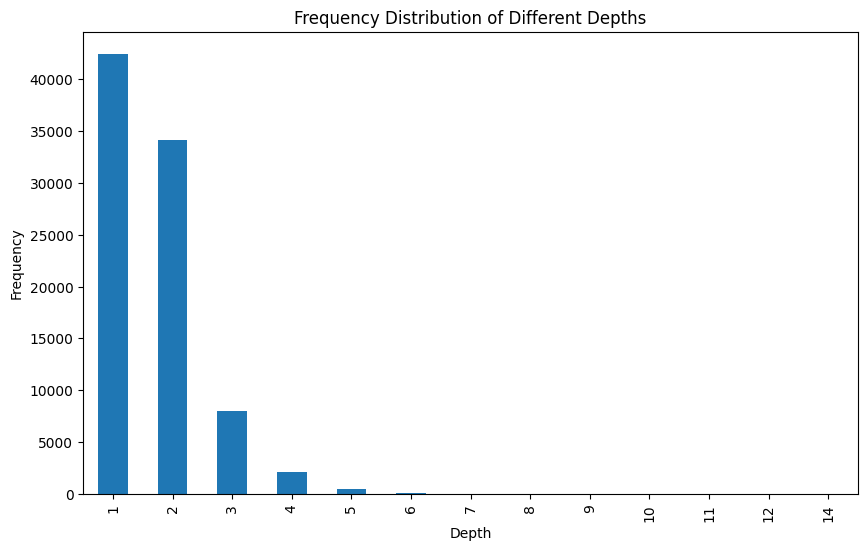

In [ ]:
df_to_plot = pd.DataFrame({'Depth': sorted_depth_freq})

# Plotting Frequency Distribution
plt.figure(figsize=(10, 6))
df_to_plot['Depth'].value_counts().sort_index().plot(kind='bar')
plt.title('Frequency Distribution of Different Depths')
plt.xlabel('Depth')
plt.ylabel('Frequency')
plt.show()


Filtering out rows containing a missing claim 1 or claim 2. These rows are not needed during this probing task.

In [ ]:
# Convert to numeric; 'coerce' will set non-convertible strings to NaN
level_df['Claim1_numeric'] = pd.to_numeric(level_df['Claim1'], errors='coerce')
level_df['Claim2_numeric'] = pd.to_numeric(level_df['Claim2'], errors='coerce')

# Filter rows where both 'Claim1_numeric' and 'Claim2_numeric' are NaN, i.e., original claims are not numbers
filtered_level_df = level_df[pd.isna(level_df['Claim1_numeric']) & pd.isna(level_df['Claim2_numeric'])]

# Drop the temporary columns used for filtering
filtered_level_df = filtered_level_df.drop(columns=['Claim1_numeric', 'Claim2_numeric'])


In [ ]:
# Convert 'Base_Claim_Text' to numeric; 'coerce' will set non-convertible strings to NaN
level_df['Base_Claim_Text_numeric'] = pd.to_numeric(level_df['Base_Claim_Text'], errors='coerce')

# Keep rows where 'Base_Claim_Text_numeric' is NaN, i.e., original Base_Claim_Text is not a number
filtered_level_df = level_df[pd.isna(level_df['Base_Claim_Text_numeric'])]

# Drop the temporary column used for filtering
filtered_level_df = filtered_level_df.drop(columns=['Claim1_numeric', 'Claim2_numeric', 'Base_Claim_Text_numeric'])


In [ ]:
filtered_level_df.head()

,Claim1,Claim2,Base_Claim_Text,Label,Depth_Difference,Parent_Node_Text1,Parent_Node_Text2
1,Tablets have a search function allowing reader...,"People are getting used to brief reading, losi...",K12 teachers should replace textbooks with pro...,0,"(-1, -1)",Textbooks save teachers [a great amount of tim...,Online resources tend to be briefer than books.
2,Green technology has quite a significant econo...,"There is no 100% clean source of energy, we ne...",Better for the environment,1,"(-1, -1)",Better for the environment,Green technology has quite a significant econo...
4,Lust does not always lead to sex.,Risk can be thrilling and pleasurable.,Sex is not worth the costs.,1,"(-1, -1)",Lust is considered to be one of the seven dead...,"Although life itself is a risky endeavor, it i..."
5,If the two data points don't lie on the linear...,The result is the same. The /perception/ of t...,Graph 1A is better than Graph 1[\(Link to grap...,0,"(-1, -1)",Graph 1A is better than Graph 1[\(Link to grap...,Able to get a more conclusive result
6,"This ""money pit"" is the source of purpose behi...",This is an act of justification that demonstra...,The military industrial complex is a money pit...,1,"(-1, -1)",The military industrial complex is a money pit...,"This ""money pit"" is the source of purpose behi..."


In [ ]:
filtered_level_df.to_csv("/content/drive/MyDrive/Can Language Models Follow Discussions?/4/filtered_level_df.csv", index=True)

In [ ]:
def main_function_4(node_df, probe_name=""):
    """
    Main function to generate data for probing task 4.
    """
    # Generate examples and labels
    # examples = generate_examples(node_df, max_examples=2000000)  # Uncomment and adjust the max_examples as needed

    # Convert examples to DataFrame and save for other tasks
    columns = ['Claim1', 'Parent_Node_Text1', 'Claim2', 'Parent_Node_Text2', 'Base_Claim_Text', 'Label', 'Depth_Difference']
    example_df = pd.DataFrame(node_df, columns=columns)
    #example_df.to_csv(f"{probe_name}_examples.csv", index=False)

    # Reset index for proper alignment
    example_df = example_df.reset_index(drop=True)

    # Split the data into 4 folds with different test sets (k-fold)
    example_df = split_into_folds(example_df)

    # Initialize empty DataFrame with only the needed columns
    columns_needed = ['index', 'inputs', 'context', 'topic', 'org_label', 'set-0', 'set-1', 'set-2', 'set-3', 'id', 'string_label', 'label']
    final_df = pd.DataFrame(columns=columns_needed)

    # Fill in the DataFrame
    final_df['index'] = example_df.index + 1  # Index starting from 1
    final_df['id'] = final_df['index']  # 'id' is the same as 'index'
    final_df['inputs'] = example_df.apply(lambda row: (row['Claim1'], row['Claim2']), axis=1)  # Combine both claims
    final_df['context'] = example_df['Base_Claim_Text']  # Base claim as context
    final_df['topic'] = example_df['Base_Claim_Text']  # Base claim as topic
    final_df['org_label'] = example_df['Label'].map({1: 'Same Level', 0: 'Different Level'})  # Original label as string
    final_df['string_label'] = final_df['org_label']  # String label is the same as org_label
    final_df['label'] = example_df['Label']  # Numerical label


    # Transfer the set columns from example_df to final_df
    for set_column in ['set-0', 'set-1', 'set-2', 'set-3']:
        final_df[set_column] = example_df[set_column]

    # Verify the final_df before saving
    #print("Before saving:", final_df.head())

    # Save
    final_df = save_all_folds_in_one(final_df, probe_name, probe_number=4)

    #print("Data processing and saving complete.")

    return final_df


final_df_4 = main_function_4(filtered_level_df, "different_depths")
final_df_4.head(10)


After column alignment in save_all_folds_in_one:     index                                             inputs  \
0      1  (Tablets have a search function allowing reade...   
1      2  (Green technology has quite a significant econ...   
2      3  (Lust does not always lead to sex., Risk can b...   
3      4  (If the two data points don't lie on the linea...   
4      5  (This "money pit" is the source of purpose beh...   

                                             context  \
0  K12 teachers should replace textbooks with pro...   
1                         Better for the environment   
2                        Sex is not worth the costs.   
3  Graph 1A is better than Graph 1[\(Link to grap...   
4  The military industrial complex is a money pit...   

                                               topic        org_label  set-0  \
0  K12 teachers should replace textbooks with pro...  Different Level   test   
1                         Better for the environment       Same Level    d

,index,inputs,context,topic,org_label,set-0,set-1,set-2,set-3,id,string_label,label
0,1,(Tablets have a search function allowing reade...,K12 teachers should replace textbooks with pro...,K12 teachers should replace textbooks with pro...,Different Level,test,train,train,dev,1,Different Level,0
1,2,(Green technology has quite a significant econ...,Better for the environment,Better for the environment,Same Level,dev,test,train,train,2,Same Level,1
2,3,"(Lust does not always lead to sex., Risk can b...",Sex is not worth the costs.,Sex is not worth the costs.,Same Level,train,dev,test,train,3,Same Level,1
3,4,(If the two data points don't lie on the linea...,Graph 1A is better than Graph 1[\(Link to grap...,Graph 1A is better than Graph 1[\(Link to grap...,Different Level,train,train,dev,test,4,Different Level,0
4,5,"(This ""money pit"" is the source of purpose beh...",The military industrial complex is a money pit...,The military industrial complex is a money pit...,Same Level,test,train,train,dev,5,Same Level,1
5,6,(Article 11\nFreedom of expression and informa...,Is the Spanish Government acting in accordance...,Is the Spanish Government acting in accordance...,Different Level,dev,test,train,train,6,Different Level,0
6,7,(This could be a little problematic as people ...,Nintendo should allow for fan-games and modifi...,Nintendo should allow for fan-games and modifi...,Same Level,train,dev,test,train,7,Same Level,1
7,8,(The direct payment is not direct enough and i...,Discuss the view that the EU CAP \(Common Agri...,Discuss the view that the EU CAP \(Common Agri...,Different Level,train,train,dev,test,8,Different Level,0
8,9,(Looking at the primary online forum for owner...,Sex robots offer companionship to people who a...,Sex robots offer companionship to people who a...,Same Level,test,train,train,dev,9,Same Level,1
9,10,(Bayesian analysis does not guarantee objectiv...,"[Richard Carrier,](https://en.m.wikipedia.org/...","[Richard Carrier,](https://en.m.wikipedia.org/...",Same Level,dev,test,train,train,10,Same Level,1
